In [1]:
%load_ext rpy2.ipython

import pandas as pd
import networkx as nx
import warnings
import numpy as np
import microbe_directory as md
import seaborn as sns

from matplotlib import pyplot as plt        
import matplotlib.patches as mpatches


from capalyzer.packet_parser import DataTableFactory, NCBITaxaTree, annotate_taxa, TaxaTree
from capalyzer.packet_parser.data_utils import group_small_cols
from capalyzer.packet_parser.diversity_metrics import (
    shannon_entropy, richness, chao1, rarefaction_analysis
)
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, cophenet, leaves_list
from scipy.spatial.distance import squareform, pdist, jensenshannon

from os.path import join
from metasub_utils.packet_parse import MetaSUBTableFactory
#from metasub_utils.packet_parse.metadata_ontology import add_ontology
#from capalyzer.packet_parser.experimental import umap
from capalyzer.packet_parser.data_utils import group_small_cols
from capalyzer.packet_parser.normalize import proportions, prevalence
from plotnine import *
from scipy.cluster.hierarchy import fcluster
from matplotlib import pyplot as plt

from capalyzer.constants import MICROBE_DIR

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm 
from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
)

warnings.filterwarnings('ignore')
NAN = float('nan')
PACKET_DIR = '/home/dcdanko/Dropbox/resources_and_shared/metasub_data_packets/release_packet_jun12_2019/'
PACKET_DIR = '/home/dcdanko/Dropbox/resources_and_shared/metasub_data_packets/data_packet_2020_02_23_16_12'
ncbi_tree = NCBITaxaTree.parse_files()
city_meta = pd.read_csv(PACKET_DIR + '/metadata/city_metadata.csv', index_col=0)

/home/dcdanko/miniconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
def to_title(el):
    sel = str(el)
    if not el:
        return el
    tkns = sel.split('_')
    tkns = [tkn[0].upper() + tkn[1:] for tkn in tkns if tkn]
    return ' '.join(tkns)


def categorical_continents(continents):
    return pd.Categorical(
        pd.Series(continents).map(to_title),
        categories=[
            'North America',
            'East Asia',
            'Europe',
            'Sub Saharan Africa',
            'South America',
            'Middle East',
            'Oceania',
            'Nan',
        ],
        ordered=True,
    )

def normalize_surface(el):
    try:
        el = el.lower()
    except AttributeError:
        return el
    el = '_'.join(el.split())
    return {
         'ground': 'floor',
         'palm_left': 'human_hand',
         'vert_pole': 'pole',
         'palm_right': 'human_hand',
         'pedestrian_crossing_button': 'button',
         'wooden bench': 'seat',
         'gargabe_can': 'garbage',
         'horiz_pole': 'railing',
         'stairwell railing': 'railing',
         'bike kiosk': 'kiosk',
         'bench1': 'seat',
         'kiosk2': 'kiosk',
         'kiosk1': 'kiosk',
         'ticket_machine': 'kiosk',
         'escalator_handrail': 'railing',
         'bench2': 'seat',
         'lift_buttons': 'button',
         'overhead_handrail': 'railing',
         'poll': 'pole',
        'garbage_can': 'garbage',
        'bench': 'seat',
        'door_handle;door_handle': 'door_knob',
        'glass': 'window',
        'ceiling_rail': 'railing',
        'seat_rail': 'railing',
        'ticket_hall;ticket_machine': 'kiosk',
        'bench;platform': 'seat',
        'platform;bench': 'seat',
        'ticket_machine;ticket_hall': 'kiosk',
        'wooden_bench': 'seat',
        'stairwell_railing': 'railing',
        'trolley_handle': '',
        'turnstile_or_alternatives;turnstile_or_alternatives': 'turnstile',
        'ticket_kiosks;ticket_kiosks': 'kiosk',
        'ticket_machine;ticket_machine': 'kiosk',
        'station_eletronic_kiosk': 'kiosk',
        'station_railing': 'railing',
        'station_seat': 'seat',
        'center_seat': 'seat',
        'negative_control_(air)': '',
        'ceiling_rail;ceiling_rail': 'railing',
        'rail': 'railing',
        'seat_near_door': 'seat',
        'ticketing_machine;ticketing_machine_': 'kiosk',
        'jetway_1_seats_waiting_area': 'seat',
    }.get(el, el)


def add_ontology(metadata):
    """Return a pandas dataframe with metadata and MetaSUB ontologies."""
    metadata = add_surface_ontology(metadata)
    metadata = add_place_ontology(metadata)
    return metadata


def has_keyword(target, *queries):
    try:
        for query in queries:
            if query in target:
                return True
    except TypeError:
        pass
    return False


def add_surface_ontology(metadata):
    """Return a pandas dataframe with metadata and surface ontologies."""
    metadata, tbl = metadata.copy(), {}
    for val in metadata['surface_material'].unique():
        if has_keyword(val, 'glass', 'metal', 'steel', 'copper'):
            tbl[val] = ('metal', 'impermeable')
        elif has_keyword(val, 'stone', 'marble', 'ceramic', 'concrete', 'cement', 'granite'):
            tbl[val] = ('stone', 'impermeable')
        elif has_keyword(val, 'plastic', 'rubber', 'vinyl', 'pvc', 'formica'):
            tbl[val] = ('plastic', 'impermeable')
        elif has_keyword(val, 'fabric', 'cloth', 'carpet'):
            tbl[val] = ('fabric', 'permeable')
        elif has_keyword(val, 'hand', 'flesh', 'wood', 'leather', 'fiber'):
            tbl[val] = ('biological', 'permeable')
        elif has_keyword(val, 'control'):
            tbl[val] = ('control', 'control')
        else:
            tbl[val] = (NAN, NAN)
    metadata['surface_ontology_fine'] = metadata['surface_material'].apply(lambda x: tbl[x][0])
    metadata['surface_ontology_coarse'] = metadata['surface_material'].apply(lambda x: tbl[x][1])
    return metadata


def add_place_ontology(metadata):
    """Return a pandas dataframe with metadata and place ontologies."""
    metadata = metadata.copy()
    metadata['coastal'] = metadata.apply(coastal, result_type='reduce', axis=1)
    return metadata


def coastal(row):
    if row['coastal_city'] == 'yes':
        return ('coastal', 'coastal')
    if float(row['city_elevation_meters']) > 1000:
        return ('high altitude', 'not_coastal')
    return ('low altitude', 'not_coastal')


from umap import UMAP


def umap(mytbl, **kwargs):
    """Retrun a Pandas dataframe with UMAP, make a few basic default decisions."""
    metric = 'jaccard'
    if mytbl.shape[0] == mytbl.shape[1]:
        metric = 'precomputed'
    n_comp = kwargs.get('n_components', 2)
    umap_tbl = pd.DataFrame(UMAP(
        n_neighbors=kwargs.get('n_neighbors', min(100, int(mytbl.shape[0] / 4))),
        n_components=n_comp,
        metric=kwargs.get('metric', metric),
        random_state=kwargs.get('random_state', 42)
    ).fit_transform(mytbl))
    umap_tbl.index = mytbl.index
    umap_tbl = umap_tbl.rename(columns={i: f'C{i}' for i in range(n_comp)})
    return umap_tbl

In [3]:



class MetaSUBFiguresData:

    def __init__(self, packet_dir, ncbi_tree=None):
        self.tabler = DataTableFactory(packet_dir, metadata_tbl='metadata/complete_metadata.csv')
        print(self.tabler.metadata.shape)
        self.tabler.metadata = add_ontology(self.tabler.metadata)
        self.tabler.metadata['city_elevation'] = self.tabler.metadata['coastal'].map(lambda el: el[1])
        self.tabler.metadata['coastal'] = self.tabler.metadata['coastal'].map(lambda el: el[0])
        self.tabler.metadata['continent'] = categorical_continents(self.tabler.metadata['continent'])
        self.tabler.metadata['city'] = self.tabler.metadata['city'].map(to_title)
        no_air = self.tabler.metadata.query('project != "CSD17_AIR"')
        self.tabler = self.tabler.copy(new_metadata=no_air)
        self.meta = self.tabler.metadata
        self._ncbi_tree = ncbi_tree
        self._wide_taxa = None
        self._long_taxa = None
        self._taxa_sample_order = None
        self._wide_phyla = None
        self.core_thresh = 0.97
        self.sub_core_thresh = 0.7
        self.periph_thresh = 0.25
        self._taxa_umap = None
        
    @property
    def taxa_sample_order(self):
        phyla = group_small_cols(self.wide_phyla_rel, top=4)
        if self._taxa_sample_order is None:
            self._taxa_sample_order = phyla.index[leaves_list(
                linkage(
                    squareform(self.tabler.beta_diversity(phyla, metric='jensenshannon')),
                    'average'
                )
            )]
        return self._taxa_sample_order
        
    @property
    def fraction_assigned(self):
        return self.build_fraction_assigned()

    @property
    def ncbi_tree(self):
        if self._ncbi_tree is None:
            self._ncbi_tree = NCBITaxaTree.parse_files()
        return self._ncbi_tree

    @property
    def wide_taxa(self):
        if self._wide_taxa is None:
            self._wide_taxa = self.build_wide_taxonomy()
        return self._wide_taxa

    @property
    def wide_taxa_rel(self):
        return proportions(self.wide_taxa)

    @property
    def wide_phyla(self):
        if self._wide_phyla is None:
            self._wide_phyla = self.tabler.taxonomy(rank='phylum')
            self._wide_phyla = self._wide_phyla.loc[self._wide_phyla.index.isin(self.meta.index)]
        return self._wide_phyla

    @property
    def wide_phyla_rel(self):
        return proportions(self.wide_phyla)

    @property
    def function_groups(self):
        return self.build_functional_groups()

    @property
    def amrs(self):
        return self.build_amrs()

    @property
    def amr_genes(self):
        return self.build_amr_genes()

    @property
    def emp(self):
        return self.build_soil_comparison()

    @property
    def hmp(self):
        return self.build_hmp_comparison()

    @property
    def rps(self):
        return self.build_rps()
    
    @property
    def long_taxa(self):
        if self._long_taxa is None:
            self._long_taxa = self.build_long_taxa()
        return self._long_taxa
    
    @property
    def taxa_umap(self):
        if self._taxa_umap is None:
            taxa_umap = umap(self.wide_taxa > 0, n_neighbors=100)
            taxa_umap['continent'] = self.meta['continent']
            taxa_umap['city'] = self.meta['city']
            taxa_umap['climate'] = self.meta['city_koppen_climate']
            taxa_umap['lat'] = self.meta['latitude']
            taxa_umap['lon'] = self.meta['longitude']
            taxa_umap = taxa_umap.query('continent != "Nan"')
            self._taxa_umap = taxa_umap
        return self._taxa_umap

    def build_long_taxa(self):
        long_taxa = pd.read_csv(join(self.tabler.packet_dir, 'taxonomy/refseq.krakenhll_longform.csv.gz'))
        long_taxa = long_taxa.rename(columns={
            'Unnamed: 0': 'sample',
            'Unnamed: 1': 'taxa_name',
            'Unnamed: 2': 'taxa_id',
            'Unnamed: 3': 'rank',
            'Unnamed: 4': 'mpa',
        })
        sample_list = self.tabler.metadata.index
        long_taxa = long_taxa.loc[long_taxa['sample'].isin(sample_list)]
        long_taxa = long_taxa.query('rank == "species"')
        for col in ['reads', 'kmers', 'tax_reads']:
            long_taxa[col] = long_taxa[col].fillna(0).map(int)
        for col in ['dup', 'cov', 'percent']:
            long_taxa[col] = long_taxa[col].fillna(0).map(float)

        long_taxa['kmer_read_ratio'] = long_taxa['kmers'] / long_taxa['reads']

        long_taxa = long_taxa.query('kmer_read_ratio >= 2.5')
        long_taxa = long_taxa.query('kmers >= 64')
        long_taxa = long_taxa.query('reads >= 3')
        long_taxa = long_taxa.query('taxa_name != "Human endogenous retrovirus"')
        long_taxa = long_taxa.query('taxa_name != "Human endogenous retrovirus K"')
        long_taxa = long_taxa.loc[long_taxa['sample'].isin(self.meta.index)]
        return long_taxa

    def build_soil_comparison(self):
        emp = pd.read_csv(
            self.tabler.packet_dir + '/other/metasub_soil_mash_comparison.csv',
            names=['sample_name', 'emp_sample', 'jaccard', 'pval', 'hashes']
        )
        emp = emp.loc[emp['sample_name'].isin(self.meta.index)]
        emp['continent'] = categorical_continents([self.meta.loc[sn]['continent'] for sn in emp['sample_name']])
        # emp['surface'] = [self.meta.loc[sn]['surface_ontology_fine'] for sn in emp['sample_name']]
        emp = emp.dropna()
        emp = emp.query('continent != "Nan"')
        return emp

    def build_hmp_comparison(self):
        hmp = pd.read_csv(
            self.tabler.packet_dir + '/other/metasub_hmp_mash_comparison.csv',
            names=['sample_name', 'hmp_sample', 'hmp_site_fine', 'body_site', 'jaccard', 'pval', 'hashes']
        )
        hmp = hmp.loc[hmp['sample_name'].isin(self.meta.index)]
        hmp['continent'] = categorical_continents([self.meta.loc[sn]['continent'] for sn in hmp['sample_name']])
        # hmp['surface'] = [self.meta.loc[sn]['surface_ontology_fine'] for sn in hmp['sample_name']]
        hmp = hmp.dropna()
        hmp = hmp.query('continent != "Nan"')
        return hmp

    def build_wide_taxonomy(self):
        """Return a pandas df with species in columns, samples in rows. Values are read counts."""
        # return self.tabler.taxonomy()
        return self.long_taxa.pivot(index='sample', columns='taxa_name', values='reads').fillna(0)


    def build_functional_groups(self):
        paths = self.tabler.pathways()
        mypaths = paths[[el for el in paths.columns if 'unclassified' not in el and 'UNINTEG' not in el]]
        co = mypaths.corr()
        co['path_1'] = co.index
        co = co.melt(id_vars=['path_1'])
        co.columns = ['path_1', 'path_2', 'value']
        co = co.query('value > = 0.75')

        def wordcloud(paths):
            tbl = {}
            for path in paths:
                for word in path.split():
                    tbl[word] = 1 + tbl.get(word, 0)
            stop_words = [
                'of',
                'and',
                'I',
                'II',
                'III',
                'IV',
                '--',
                'to',
                'via',
                'pathway',
                'from',
                'VI',
            ]

            def clean_word(word):
                return word.replace('(', '').replace(')', '')

            tbl = {clean_word(word): val for word, val in tbl.items() if clean_word(word) not in stop_words}
            otbl = sorted([(k, v) for k, v in tbl.items()], key=lambda x: -x[1])
            tbl = [k for k, v in otbl if v > 1]
            tbl = [k for k in tbl if len(k) > 3 and 'PWY' not in k]
            if len(tbl) < 3:
                tbl = [k for k, _ in otbl if 'PWY' not in k]
            return tbl[:10]

        G = nx.Graph()
        for _, row in co.iterrows():
            G.add_edge(row['path_1'], row['path_2'])

        n, p = 0, 0
        comps = [comp for comp in nx.connected_components(G) if len(comp) > 1]
        wcs = {f'COMP_{i}': (comp, wordcloud(comp)) for i, comp in enumerate(comps)}
        for name, (comp, wc) in wcs.items():
            if len(comp) == 1:
                continue
            n += 1
            p += len(comp)
            these_paths = mypaths[comp].sum(axis=1)
            mypaths = mypaths.drop(columns=comp)
            mypaths[name] = these_paths

        mypaths = proportions(mypaths)
        mypaths = group_small_cols(mypaths, top=6)
        cats = {
            'COMP_7': 'Branched Amino Acid Biosynthesis',
            'COMP_11': 'Lysine, Threonine, Methionine Biosynthesis',
            'COMP_14': 'Fatty Acid Biosynthesis',
            'COMP_49': 'Ribonucleotide Biosynthesis',
            'COMP_51': 'Nucleotide Biosynthesis (1)',
            'COMP_67': 'Nucleotide Biosynthesis (2)',
        }
        mypaths = mypaths.rename(columns=cats)
        paths = {
            'PWY-3781: aerobic respiration I (cytochrome c)': 'Aerobic Respiration',
            'PWY-7219: adenosine ribonucleotides de novo biosynthesis': 'Nucleotide Biosynthesis (3)',
        }
        mypaths = mypaths.rename(columns=paths)
        mypaths['Nucleotide Biosynthesis'] = mypaths['Nucleotide Biosynthesis (1)'] + mypaths['Nucleotide Biosynthesis (2)']
        mypaths = mypaths.drop(columns=['Nucleotide Biosynthesis (1)', 'Nucleotide Biosynthesis (2)'])
        mypaths['sample'] = mypaths.index
        mypaths['continent'] = self.tabler.metadata['continent']
        mypaths['continent'] = [str(el) for el in mypaths['continent']]
        mypaths = mypaths.melt(id_vars=['sample', 'continent'])
        mypaths = mypaths.dropna()

        return mypaths

    def build_amrs(self, kind='class'):
        """TODO: REVIEW."""
        amrs = self.tabler.amrs(kind=kind, remove_zero_rows=False).drop(columns=['Elfamycins']).dropna()
        #amrs = (amrs.T / (amrs.T.sum() + 0.000001)).T
        return amrs
    
    def build_amrs_raw(self, kind='class'):
        """TODO: REVIEW."""
        amrs = self.tabler.amrs(kind=kind, remove_zero_rows=False).dropna()
        #amrs = (amrs.T / (amrs.T.sum() + 0.000001)).T
        return amrs

    def build_amr_genes(self):
        """TODO: REVIEW."""
        amrs = self.tabler.amrs(kind='gene', remove_zero_rows=False).dropna()
        amrs = (amrs.T / (amrs.T.sum() + 0.000001)).T
        return amrs

    def build_unclassified(self):
        non_human_unkown = (rps['unknown'] / (1 - rps['host'])).mean()
        non_human_known = 1 - non_human_unkown
        non_human_blast_nt_aligned = (self.tabler.csv_in_dir('other/nt_aligned_counts.csv') / 10000)

    def build_rps(self):
        rps = self.tabler.read_props()
        rps['continent'] = self.tabler.metadata['continent']
        # rps['surface'] = self.tabler.metadata['surface_ontology_fine']
        rps = rps.dropna()
        rps = rps.query('continent != "Nan"')

        return rps
    
    def build_fraction_assigned(self):

        def parse_tbl(val):
            fname = f'other/fraction_aligned_with_refseq_{val}.2020_02_22_13_11.csv'
            fname = f'/home/dcdanko/Dropbox/resources_and_shared/metasub_data_packets/metasub_data_packet_jan_14_2020/{fname}'
            tbl = pd.read_csv(fname).rename(columns={
                'Unnamed: 0': 'sample_name',
                'any': 'Any Database',
                'metasub_mags': 'MetaSUB MAGs',
                'ncbi_nt': 'NCBI-NT',
                'passoli': 'Passoli MAGs, 2019',
                'refseq': 'RefSeq',
                'unaligned': 'Unaligned',
            })
            tbl['percent_id'] = str(val)
            tbl = tbl.dropna()
            tbl['Unaligned or MetaSUB'] = tbl['Unaligned'] + tbl['metasub_mags_only']
            tbl = tbl.drop(columns=['metasub_mags_only'])
            return tbl

        tbls = [parse_tbl(val) for val in [80, 90, 95]]
        tbl = pd.concat(tbls)
        tbl = tbl.melt(id_vars=['sample_name', 'percent_id'])
        tbl['value'] /= 10 * 1000  # we aligned 10k reads from each sample

        def cont(s):
            try:
                return self.meta.loc[s, 'continent']
            except KeyError:
                return 'Nan'

        tbl['continent'] = categorical_continents([cont(s) for s in tbl['sample_name']])
        tbl = tbl.dropna()
        tbl = tbl.query('continent != "Nan"')
        tbl = tbl.loc[tbl['sample_name'].isin(self.meta.index)]
        return tbl
    
    def city_amr_classifier(self):
        return self.city_classifier(master_taxa=self.amr_genes)
    
    def city_classifier(self, master_taxa=None, n_classifiers=200):
        if master_taxa is None:
            master_taxa = proportions(self.wide_taxa) #> 0 # .0001

        def one_trial(n, e):
            taxa = master_taxa
            if n > 0:
                taxa = taxa.sample(n)
            cities = self.meta.loc[taxa.index, 'city']
            feature, name_map = pd.factorize(cities)
            train_taxa, test_taxa, train_feature, test_feature = train_test_split(taxa, feature, test_size=0.1, random_state=None)
            model = RandomForestClassifier(n_estimators=e, random_state=None)
            # model = svm.SVC(kernel='linear', probability=True)
            model.fit(train_taxa, train_feature)
            predictions = model.predict(test_taxa).round()
            return {
                'accuracy': accuracy_score(test_feature, predictions),
                'precision': precision_score(test_feature, predictions, average="micro"),
                'recall': recall_score(test_feature, predictions, average="micro"),
                'train_size': train_taxa.shape[0],
                'test_size': test_taxa.shape[0],
                'e': e,
            }
    
        tbl = []
        for i in range(5):
            print(i)
            for n in [500, 1000, 1500, 2000, 2500, 3000, 3500, -1]:
                val = one_trial(n, n_classifiers)
                val['iter'] = i
                tbl.append(val)

        tbl = pd.DataFrame(tbl)
        return tbl

    def endemicity_scores(self, grp='continent'):
        taxa = (self.wide_taxa > 0).loc[self.meta[grp].index].fillna(False)
        idf = 1 / (taxa.groupby(self.meta[grp]).sum() > 0).mean()
        tf = taxa.groupby(self.meta[grp]).mean()
        tfidf = (tf * idf)
        return tfidf
    
    def leave_one_city_out(self):
        TAXA = self.wide_taxa_rel

        COLS = [
            'city',
            'coastal_city', 'city_total_population', 'city_population_density', 
            'city_ave_june_temp_c', 'continent', 'city_koppen_climate',  
            'surface_ontology_fine', 'surface_ontology_coarse', 'city_elevation'
        ]
        METADATA = self.meta[COLS]
        METADATA['city_ave_june_temp_c'] = pd.cut(METADATA['city_ave_june_temp_c'], 3, labels=['low', 'medium', 'high'])
        METADATA['city_population_density'] = pd.cut(METADATA['city_population_density'], 3, labels=['low', 'medium', 'high'])
        METADATA['city_total_population'] = pd.cut(METADATA['city_total_population'], 3, labels=['low', 'medium', 'high'])


        def prep_data(leave_out_city, feature_to_predict):
            cities = METADATA.loc[TAXA.index, 'city']
            train_cities = cities[cities != leave_out_city]
            test_cities = cities[cities == leave_out_city]
            train_taxa = TAXA.loc[train_cities.index]
            test_taxa = TAXA.loc[test_cities.index]

            feature = METADATA.loc[TAXA.index, feature_to_predict]
            feature, name_map = pd.factorize(feature)
            test_feature = feature[TAXA.index.isin(test_cities.index)]
            train_feature = feature[TAXA.index.isin(train_cities.index)]
            test_names = list(test_cities.index)

            return (train_taxa, test_taxa), (train_feature, test_feature), name_map, test_names


        def train_test_model(args):
            leave_out_city, feature_to_predict = args
            (train_taxa, test_taxa), (train_feature, test_feature), name_map, test_names = prep_data(leave_out_city, feature_to_predict)
            classifier = RandomForestClassifier(n_estimators=100, random_state=0)
            #classifier = LinearSVC(penalty='l2', dual=True, random_state=99)
            classifier.fit(train_taxa, train_feature)

            predictions = classifier.predict(test_taxa).round()
            confidences = [0] * len(predictions) # np.max(classifier.predict_proba(test_taxa), axis=1)
            assert len(predictions) == len(confidences)

            predictions = [name_map[el] for el in predictions]
            actual = [name_map[el] for el in test_feature]

            return pd.DataFrame([{
                    'uuid': test_names[i],
                    'predicted': predictions[i],
                    'confidence': confidences[i],
                    'actual': actual[i],
                    'city': leave_out_city,
                    'feature': feature_to_predict,
                } 
                for i in range(len(predictions))
            ])

        tbls = []
        for city in self.meta.loc[TAXA.index, 'city'].unique():
            if city in ['other', 'tsuruoka']:
                continue
            print(city)
            for feature in COLS:
                if feature in ['city']:
                    continue
                tbls.append(train_test_model((city, feature)))
        tbl = pd.concat(tbls)
        return tbl

    def leave_one_city_out_null(self):
        COLS = [
            'city',
            'coastal_city', 'city_total_population', 'city_population_density', 
            'city_ave_june_temp_c', 'continent', 'city_koppen_climate',  
            'surface_ontology_fine', 'surface_ontology_coarse', 'city_elevation'
        ]
        METADATA = self.meta[COLS]
        METADATA['city_ave_june_temp_c'] = pd.cut(METADATA['city_ave_june_temp_c'], 3, labels=['low', 'medium', 'high'])
        METADATA['city_population_density'] = pd.cut(METADATA['city_population_density'], 3, labels=['low', 'medium', 'high'])
        METADATA['city_total_population'] = pd.cut(METADATA['city_total_population'], 3, labels=['low', 'medium', 'high'])


        def null_model(leave_out_city, feature_to_predict):
            cities = METADATA['city']
            train_cities = cities[cities != leave_out_city]
            feature = METADATA.loc[cities.index, feature_to_predict]
            proportions = feature.value_counts() / feature.shape[0]
            val = str(METADATA.loc[METADATA['city'] == leave_out_city, feature_to_predict][0])
            try:
                return proportions[val]
            except KeyError:
                return 0

        tbl = []
        for city in self.meta['city'].unique():
            if city in ['other', 'tsuruoka']:
                continue
            for feature in COLS:
                if feature in ['city']:
                    continue
                tbl.append({
                    'city': city,
                    'feature': feature,
                    'accuracy': null_model(city, feature),
                })
        tbl = pd.DataFrame(tbl)
        return tbl
    
    def city_classification_random_accuracy(self):
        city_counts = self.meta['city'].value_counts()
        city_counts_sq = city_counts.map(lambda el: el * el)
        return city_counts_sq.sum() / (city_counts.sum() ** 2)

    
figs_data = MetaSUBFiguresData(PACKET_DIR, ncbi_tree=ncbi_tree)

(5132, 41)


In [4]:
def clean_controls(el):
    return {
        'ctrl cities': 'Background Control',
        'dry tube': 'Lab Control',
        'dry tube & swab': 'Lab Control',
        'negative_control': 'Lab Control',
        'positive_control': 'Positive Control',
        'poszymo': 'Positive Control',
        'tube & rna/dna out': 'Lab Control',
        'tube & rna/dna out & swab': 'Lab Control',
    }.get(el, el)


class MetaSUBFigures(object):
    
    def __init__(self, metasub_fig_data):
        self.metasub_fig_data = metasub_fig_data
    
    def __getattr__(self, attr):
        return getattr(self.metasub_fig_data, attr)

    def tbl1(self):
        """Return a pandas dataframe listing where and when samples were collected."""
        tbl = self.meta.copy()

        tbl = tbl.loc[tbl['control_type'].isna()]
        tbl = tbl.loc[~tbl['city'].isna()]
        tbl = tbl.query('continent != "Nan"')
        tbl = tbl.query('continent != "other"')
        tbl = pd.crosstab(tbl['continent'], tbl['project'])

        tbl.index.names = ['Region']
        tbl.index = tbl.index.str.replace('_', ' ').str.title()

        tbl = tbl.rename(columns={
            'OLYMPIOME - RIO': 'OLYMPIOME',
            'WINTER2014': 'PATHOMAP_WINTER', 
            'WINTER_NYC': 'PATHOMAP_WINTER',
            'PILOT': 'Pilot',
        })
        other_projs = set(list(tbl.columns[tbl.sum(axis=0) < 100]) + ['PATHOMAP_WINTER'])  
        tbl['Other'] = tbl[other_projs].sum(axis=1)
        tbl = tbl.drop(columns=other_projs)
        tbl['Total'] = tbl.sum(axis=1)

        tbl = tbl[['Pilot', 'CSD16', 'CSD17', 'Other', 'Total']]  # column order
        ctrl = self.meta.copy()
        ctrl = ctrl.loc[~ctrl['control_type'].isna()]

        ctrl['control_type'] = ctrl['control_type'].map(clean_controls)
        ctrl = pd.crosstab(ctrl['control_type'], ctrl['project'])

        ctrl.index.names = ['Region']

        other_projs = ['WINTER_NYC']
        ctrl['Other'] = ctrl[other_projs].sum(axis=1)
        ctrl = ctrl.drop(columns=other_projs)
        ctrl['Total'] = ctrl.sum(axis=1)
        cols = [
            col for col in ['Pilot', 'CSD16', 'CSD17', 'Other', 'Total']
            if col in ctrl.columns
        ]
        ctrl = ctrl[cols]

        tbl = pd.concat([tbl, ctrl])
        tbl = tbl[['Pilot', 'CSD16', 'CSD17', 'Other', 'Total']]
        tbl = tbl.fillna(0)
        tbl = tbl.applymap(int)
        tbl.loc['Total'] = tbl.sum(axis=0)
        return tbl

    def sup_tbl1(self):
        """Return a pandas dataframe listing where and when samples were collected."""
        tbl = self.meta.copy()

        tbl = tbl.loc[tbl['control_type'].isna()]
        tbl = tbl.loc[~tbl['city'].isna()]
        tbl = tbl.query('city != "Nan"')
        tbl = tbl.query('city != "other"')
        tbl = pd.crosstab(tbl['city'], tbl['project'])

        tbl['Region'] = self.meta.groupby('city').apply(lambda x: x['continent'].iloc[0])
        tbl['Region'] = tbl['Region'].str.replace('_', ' ').str.title()
        tbl.index = tbl.index.str.replace('_', ' ').str.title()

        tbl = tbl.set_index('Region', append=True)
        tbl = tbl.reorder_levels(['Region', 'city'])
        tbl = tbl.sort_index()

        tbl = tbl.rename(columns={
            'OLYMPIOME - RIO': 'OLYMPIOME',
            'WINTER2014': 'PATHOMAP_WINTER', 
            'WINTER_NYC': 'PATHOMAP_WINTER',
            'PILOT': 'Pilot',
        })
        other_projs = set(list(tbl.columns[tbl.sum(axis=0) < 100]) + ['PATHOMAP_WINTER'])
        tbl['Other'] = tbl[other_projs].sum(axis=1)
        tbl = tbl.drop(columns=other_projs)
        tbl['Total'] = tbl.sum(axis=1)

        tbl = tbl[['Pilot', 'CSD16', 'CSD17', 'Other', 'Total']]  # column order

        continent_totals = tbl.groupby(level=0).sum()
        continent_totals['city'] = 'AAA Region Total'  # AAA so sort puts these first
        continent_totals = continent_totals.set_index('city', append=True)
        tbl = pd.concat([tbl, continent_totals]).sort_index()

        ctrl = self.meta.copy()
        ctrl['control_type'] = ctrl['control_type'].map(clean_controls)
        ctrl = ctrl.loc[~ctrl['control_type'].isna()]
        ctrl = pd.crosstab(ctrl['control_type'], ctrl['project'])

        ctrl.index.names = ['city']
        ctrl['Region'] = 'Control'
        ctrl = ctrl.set_index('Region', append=True)
        ctrl = ctrl.reorder_levels(['Region', 'city'])

        other_projs = ['WINTER_NYC']
        ctrl['Other'] = ctrl[other_projs].sum(axis=1)
        ctrl = ctrl.drop(columns=other_projs)
        ctrl['Total'] = ctrl.sum(axis=1)
        cols = [
            col for col in ['Pilot', 'CSD16', 'CSD17', 'Other', 'Total']
            if col in ctrl.columns
        ]
        ctrl = ctrl[cols]

        tbl = pd.concat([tbl, ctrl])
        tbl.index = tbl.index.set_levels(tbl.index.levels[1].str.replace('AAA', ''), level=1)
        tbl = tbl.fillna(0)
        return tbl

    def fig1(self, N=75):
        """Figure showing the major taxa found in the metasub data."""
        return [
            self.fig1_core_taxa_tree(),
            self.fig1_prevalence_curve(),
            self.fig1_major_taxa_curves(N=N),
            self.fig1_species_rarefaction(),
            self.fig1_reference_comparisons(),
            self.fig1_fraction_unclassified(),
        ]

    def fig1_core_taxa_tree(self):
        """Return an ETE tree showing core taxa with annotations."""

    def fig1_prevalence_curve(self):
        """Return a P9 figure showing the distribution of species prevalences."""
        prev = pd.DataFrame({
            'total': prevalence(self.wide_taxa),
            'city': self.wide_taxa.groupby(by=self.meta['city']).apply(prevalence).mean(axis=0),
        })
        n_periph = (prev['city'] < self.periph_thresh).sum()
        n_core = (prev['city'] > self.core_thresh).sum()
        n_sub_core = ((self.periph_thresh < prev['city']) & (prev['city'] < self.core_thresh)).sum()
        prev['taxa'] = prev.index
        prev_flat = prev.melt(id_vars='taxa')
        plot = (
            ggplot(prev_flat, aes(x='value', color='variable', fill='variable')) +
                geom_density(size=2, alpha=0.2) +
                theme_minimal() +
                xlab('Species Prevalence') +
                ylab('Density') +
                geom_vline(xintercept=self.periph_thresh, color='black') +
                geom_vline(xintercept=self.sub_core_thresh, color='black') +
                geom_vline(xintercept=self.core_thresh, color='black') +
                annotate(geom='label', x=0.65, y=2.9, label=f"Sub-Core {int(100 * self.sub_core_thresh)}-{int(100 * self.core_thresh)}% ({n_sub_core:,})", size=20) +
                annotate(geom='label', x=0.33, y=3.5, label=f"Peripheral, < {int(100 * self.periph_thresh)}% ({n_periph:,})", size=20) +
                annotate(geom='label', x=0.78, y=3.2, label=f"Core > {int(100 * self.core_thresh)}% ({n_core:,})", size=20) +
                scale_color_brewer(type='qualitative', palette=6, direction=1) +
                scale_fill_brewer(type='qualitative', palette=6, direction=1) +
                theme(
                    text=element_text(size=20),
                    axis_text_x=element_text(angle=0, hjust=1),
                    figure_size=(8, 8),
                    legend_position='none',
                )
        )
        return plot

    def fig1_major_taxa_curves(self, N=75):
        """Return two P9 panels showing prevalence and abundance distributions of major taxa."""
        taxa = self.wide_taxa_rel
        city = taxa.groupby(by=self.meta['city']).median()

        top_taxa = taxa.mean().sort_values(ascending=False)[:N].index
        taxa, city = 1000 * 1000 * taxa[top_taxa], 1000 * 1000 * city[top_taxa]
        taxa_prev, city_prev = prevalence(taxa), prevalence(city)
        taxa_prev = pd.DataFrame({'taxon': taxa_prev.index, 'prevalence': taxa_prev, 'names': taxa_prev.index})
        city_prev = pd.DataFrame({'taxon': city_prev.index, 'prevalence': city_prev, 'names': city_prev.index})
        taxa_mean, taxa_kurtosis, taxa_sd = taxa.mean(), taxa.kurtosis(), taxa.std()

        def add_stats(taxon):
            m, k, sd = taxa_mean[taxon], taxa_kurtosis[taxon], taxa_sd[taxon]
            return f'{taxon} ({m // 1000:.0f}k, {sd // 1000:.0f}k, {k:.0f})'

        taxa.columns = taxa.columns.to_series().apply(add_stats)
        city.columns = city.columns.to_series().apply(add_stats)
        top_taxa_stat = top_taxa.to_series().apply(add_stats)

        taxa, city = taxa.melt(), city.melt()
        taxa['variable'] = pd.Categorical(taxa['taxa_name'], categories=top_taxa_stat)
        city['variable'] = pd.Categorical(city['taxa_name'], categories=top_taxa_stat)
        taxa['kind'] = 'All Samples'
        city['kind'] = 'City Median'
        both = pd.concat([taxa, city])
        abund = (
            ggplot(both, aes(x='value', color='kind')) +
                geom_density(size=1) +
                facet_grid('variable~.', scales="free_y") +
                theme_minimal() +
                ylab('Density') +
                xlab('Abundance (PPM)') +
                scale_x_log10() +
                scale_color_brewer(type='qualitative', palette=6, direction=1) +
                labs(fill="") +
                theme(
                    axis_text_x=element_text(angle=0, hjust=1),
                    strip_text_y=element_text(angle=0, hjust=0),
                    text=element_text(size=20),
                    panel_grid_major_x=element_line(colour="grey", size=0.75),
                    panel_grid_major_y=element_blank(),
                    panel_grid_minor=element_blank(),
                    legend_position='none',
                    axis_title_y=element_blank(),
                    axis_text_y=element_blank(),
                    figure_size=(4, 40),
                    panel_border=element_rect(colour="black", fill='none', size=1),
                )
        )
        taxa_prev['kind'] = 'All Samples'
        city_prev['kind'] = 'City Median'
        taxa_prev['taxon'] = pd.Categorical(taxa_prev['taxon'], categories=top_taxa)
        city_prev['taxon'] = pd.Categorical(city_prev['taxon'], categories=top_taxa)
        both_prev = pd.concat([taxa_prev, city_prev])
        prev = (
            ggplot(both_prev, aes(x='kind', y='prevalence', fill='kind')) +
                geom_col() +
                facet_grid('taxon~.', scales="free_y") +
                theme_minimal() +
                ylab('Prevalence') +
                scale_fill_brewer(type='qualitative', palette=6, direction=1) +
                labs(color="") +
                coord_flip() +
                scale_y_continuous(breaks=(0.1, 0.5, 1)) +
                theme(
                    axis_text_x=element_text(angle=0, hjust=1),
                    axis_text_y=element_blank(),
                    axis_title_y=element_blank(),
                    strip_text_y=element_blank(),
                    text=element_text(size=20),
                    panel_grid_major=element_blank(),
                    legend_position='left',
                    figure_size=(2, 40),
                    panel_border=element_rect(colour="black", fill='none', size=1),
                )
        )
        return abund, prev

    def fig1_species_rarefaction(self, w=100):
        """Return a P9 rarefaction curve for species."""
        ns = range(w, self.wide_taxa.shape[0], w)
        rare = rarefaction_analysis(self.wide_taxa, ns=ns)
        return (
            ggplot(rare, aes(x='N', y='Taxa')) +
                geom_point(size=4, colour="black") +
                geom_smooth(color='blue') +
                theme_minimal() +
                xlab('Num. Samples') +
                theme(
                    text=element_text(size=20),
                    figure_size=(8, 8),
                )
        )

    def fig1_reference_comparisons(self):
        """Return P9 figures comparing metasub to skin and soil."""

        def my_plot(tbl, y_lab, yint, yint_lab):
            return (
                ggplot(tbl, aes(x='continent', y='jaccard', fill='continent')) +
                    geom_violin(width=1.2) +
                    geom_boxplot(fill='white', width=0.1) +
                    theme_minimal() +
                    scale_y_sqrt() +
                    ylim(0, 0.5) +
                    scale_fill_brewer(type='qualitative', palette=6, direction=1) +
                    xlab('') +
                    ylab(y_lab) +
                    geom_hline(yintercept=yint, color='red', size=4) +
                    annotate(geom='label', x='Middle East', y=(yint - 0.015), label=yint_lab, size=20) +
                    theme(
                        text=element_text(size=20),
                        figure_size=(8, 8),
                        legend_position='none',
                        axis_text_x=element_text(angle=90),
                    )
            )

        return [
            my_plot(self.emp, 'MASH Jaccard Distance to Soil', 0.16451445767195777, "Soil-Soil Mean"),
            my_plot(
                self.hmp.query('body_site == "skin"'), 'MASH Jaccard Distance to Skin',
                0.083, "Skin-Skin Mean"
            ),
        ]

    def fig1_fraction_unclassified(self):
        """Return a figure showing the fraction of reads which could not be classified."""
        return (
            ggplot(self.rps, aes(x='continent', y='unknown', fill='continent')) +
                geom_violin() +
                geom_boxplot(fill='white', width=0.1) +
                theme_minimal() +
                scale_fill_brewer(type='qualitative', palette=6, direction=1) +
                xlab('Region') +
                ylab('Fraction Unclassified DNA') +
                theme(
                    text=element_text(size=20),
                    axis_text_x=element_text(hjust=1, angle=30),
                    figure_size=(8, 8),
                    legend_position='none',
                )
        )

    def fig2(self):
        """Figure showing the variation between metasub samples."""
        return [
            self.fig2_umap(),
            self.fig2_pca_flows(),
            self.fig2_region_blocks(),
        ]

    def fig2_umap(self, color='continent', color_pal=None):
        """Return a scatter plot showing a UMAP dimensionality reduction of the data."""
        taxa_umap = self.taxa_umap
        taxa_umap = taxa_umap.query('continent != "Nan"')
        plot = (
            ggplot(taxa_umap, aes(x='C0', y='C1', color=color)) +
                geom_point(size=5.5, colour="black") +
                geom_point(size=4) +
                theme_minimal() +
                (scale_color_brewer(type='qualitative', palette=6, direction=1) if color_pal is None else color_pal) +
                theme_minimal() +
                coord_flip() +
                theme(
                    text=element_text(size=50),
                    panel_grid_major=element_blank(),
                    panel_grid_minor=element_blank(),
                    legend_position='none',
                    axis_text_x=element_blank(),
                    axis_title_x=element_blank(),
                    axis_text_y=element_blank(),
                    axis_title_y=element_blank(),
                    panel_border=element_rect(colour="black", fill='none', size=2),
                    figure_size=(16, 12),
                )
        )
        return plot

    def fig2_region_blocks(self):
        """Return three panels showing taxa, function, and amr for all samples."""
        phyla = group_small_cols(self.wide_phyla_rel, top=4)

        phyla['sample'] = phyla.index
        phyla['continent'] = self.meta['continent']
        phyla = phyla.melt(id_vars=['sample', 'continent'])
        phyla = phyla.dropna()
        phyla = phyla.query('continent != "Nan"')

        amrs = self.amrs
        #amrs = group_small_cols(self.amrs, top=5)
        cols = ['MLS', 'Multi-drug resistance', 'Phenicol', 'Rifampin', 'betalactams']
        others = [col for col in amrs.columns if col not in cols]
        others = amrs[others].sum(axis=1)
        amrs = amrs[cols]
        amrs['other'] = others
        amrs['sample'] = amrs.index
        amrs['continent'] = self.meta['continent']
        amrs = amrs.melt(id_vars=['sample', 'continent'])
        amrs = amrs.dropna()
        amrs = amrs.query('continent != "Nan"')

        funcs = self.function_groups
        funcs = funcs.dropna()
        funcs = funcs.query('continent != "Nan"')
        funcs = funcs.query('continent != "nan"')

        def my_plot(tbl, label, pal):
            tbl['sample'] = pd.Categorical(tbl['sample'], self.taxa_sample_order)
            return (
                ggplot(tbl, aes(x='sample', y='value', fill='variable', group='continent')) +
                    geom_col() +
                    facet_grid('.~continent', scales="free") +
                    scale_fill_brewer(type='qualitative', palette=pal, direction=1) +
                    theme_minimal() +
                    scale_y_sqrt(expand=(0, 0)) +
                    labs(fill=label) +
                    theme(
                        text=element_text(size=20),
                        panel_grid_major=element_blank(),
                        panel_grid_minor=element_blank(),
                        legend_position='bottom',
                        axis_text_x=element_blank(),
                        axis_title_x=element_blank(),
                        axis_text_y=element_blank(),
                        axis_title_y=element_blank(),
                        panel_border=element_rect(colour="black", size=2),
                        figure_size=(32, 4),
                    )
            )

        return [
            my_plot(phyla, 'Phyla', 6),
            my_plot(funcs, 'Pathways', 3),
            my_plot(amrs, 'AMR Class', 2),
        ]

    def fig2_pca_flows(self, n_pcs=100):
        pca = PCA(n_components=n_pcs)
        pcs = pca.fit_transform(self.wide_taxa_rel)
        pcs = pd.DataFrame(
            data=pcs,
            index=self.wide_taxa_rel.index,
            columns=[f'PC{i}' for i in range(n_pcs)]
        )
        pcs['surface'] = self.meta['surface_ontology_fine'].map(to_title)
        pcs['temperature'] = self.meta['city_ave_june_temp_c']
        pcs['pop_density'] = self.meta['city_population_density']
        pcs['continent'] = self.meta['continent']
        pcs['city_koppen_climate'] = self.meta['city_koppen_climate'].map(to_title).map(lambda t: t.split(' Clim')[0])
        pcs['sample'] = pcs.index
        pcs = pcs.loc[pcs['surface'] != 'nan']
        pcs = pcs.loc[pcs['surface'] != 'control']
        pcs = pcs.loc[pcs['continent'] != '0']
        pcs = pcs.loc[pcs['continent'] != 'Nan']
        pcs = pcs.loc[pcs['surface'] != 'Nan']
        pcs = pcs.loc[pcs['city_koppen_climate'] != 'Nan']
        var_pcs = pcs.melt(id_vars=['surface', 'sample', 'temperature', 'pop_density', 'continent', 'city_koppen_climate'])

        def scaleit(tbl, covar):
            tbl = tbl.groupby(covar).mean()
            return tbl

        def variance_bars(covar):
            var_bars = var_pcs.groupby('variable').apply(lambda tbl: scaleit(tbl, covar))
            var_bars['variable'] = [int(str(el[0]).split('PC')[1]) for el in var_bars.index]
            var_bars[covar] = [str(el[1]) for el in var_bars.index]
            if covar == 'continent':
                var_bars[covar] = categorical_continents(var_bars[covar])
            return var_bars

        def my_plot(covar, label, pal):
            bars = variance_bars(covar)
            return (
                ggplot(bars, aes(x='variable', y='value', fill=covar)) +
                    geom_bar(stat='identity') +
                    theme_minimal() +
                    scale_fill_brewer(type='qualitative', palette=pal, direction=1) +
                    xlab('Principal Components') +
                    ylab('Mean Value of Covariate') +
                    labs(fill=label) +
                    xlim(0, 25) +
                    ylim(-0.3, 0.5) +
                    ggtitle(label) +
                    theme(
                        text=element_text(size=20),
                        figure_size=(5, 12),
                        panel_grid_minor=element_blank(),
                        legend_position='right',
                    )
            )

        out = [
            my_plot('city_koppen_climate', 'Climate', 3),
            my_plot('continent', 'Region', 6),
            my_plot('surface', 'Surface', 2),
        ]
        out = [el + theme(legend_position='none') for el in out] + out
        return out

    def fig2_pca_flows_amr(self, n_pcs=100):
        pca = PCA(n_components=n_pcs)
        pcs = pca.fit_transform(self.amr_genes)
        pcs = pd.DataFrame(
            data=pcs,
            index=self.amr_genes.index,
            columns=[f'PC{i}' for i in range(n_pcs)]
        )
        pcs['surface'] = self.meta['surface_ontology_fine'].map(to_title)
        pcs['temperature'] = self.meta['city_ave_june_temp_c']
        pcs['pop_density'] = self.meta['city_population_density']
        pcs['continent'] = self.meta['continent']
        pcs['city_koppen_climate'] = self.meta['city_koppen_climate'].map(to_title).map(lambda t: t.split(' Clim')[0])
        pcs['sample'] = pcs.index
        pcs = pcs.loc[pcs['surface'] != 'nan']
        pcs = pcs.loc[pcs['surface'] != 'control']
        pcs = pcs.loc[pcs['continent'] != '0']
        pcs = pcs.loc[pcs['continent'] != 'Nan']
        pcs = pcs.loc[pcs['surface'] != 'Nan']
        pcs = pcs.loc[pcs['city_koppen_climate'] != 'Nan']
        var_pcs = pcs.melt(id_vars=['surface', 'sample', 'temperature', 'pop_density', 'continent', 'city_koppen_climate'])

        def scaleit(tbl, covar):
            tbl = tbl.groupby(covar).mean()
            return tbl

        def variance_bars(covar):
            var_bars = var_pcs.groupby('variable').apply(lambda tbl: scaleit(tbl, covar))
            var_bars['variable'] = [int(str(el[0]).split('PC')[1]) for el in var_bars.index]
            var_bars[covar] = [str(el[1]) for el in var_bars.index]
            if covar == 'continent':
                var_bars[covar] = categorical_continents(var_bars[covar])
            return var_bars

        def my_plot(covar, label, pal):
            bars = variance_bars(covar)
            return (
                ggplot(bars, aes(x='variable', y='value', fill=covar)) +
                    geom_bar(stat='identity') +
                    theme_minimal() +
                    scale_fill_brewer(type='qualitative', palette=pal, direction=1) +
                    xlab('Principal Components') +
                    ylab('Mean Value of Covariate') +
                    labs(fill=label) +
                    xlim(0, 25) +
                    ylim(-0.3, 0.5) +
                    ggtitle(label) +
                    theme(
                        text=element_text(size=20),
                        figure_size=(5, 12),
                        panel_grid_minor=element_blank(),
                        legend_position='right',
                    )
            )

        out = [
            my_plot('city_koppen_climate', 'Climate', 3),
            my_plot('continent', 'Region', 6),
            my_plot('surface', 'Surface', 2),
        ]
        out = [el + theme(legend_position='none') for el in out] + out
        return out
    
    def fig4_escores(self, grp='continent'):
        tbl = self.endemicity_scores(grp=grp)
        tbl[grp] =  tbl.index
        tbl = tbl.melt(id_vars=[grp])
        tbl = tbl.query(f'{grp} != "Nan"')
        return (
            ggplot(tbl, aes(x=grp, y='value', fill=grp)) +
                geom_violin(width=1.2) +
                geom_boxplot(fill='white', width=0.2) +
                theme_minimal() +
                scale_y_sqrt() +
                scale_fill_brewer(type='qualitative', palette=6, direction=1) +
                xlab('') +
                ylab('Endemicity of Taxa (TF-IDF)') +
                theme(
                    text=element_text(size=20),
                    figure_size=(8, 8),
                    legend_position='none',
                    axis_text_x=element_text(angle=90),
                )
        )
    
    def fig4_escores_city(self, grp='city'):
        tbl = self.endemicity_scores(grp=grp)
        tbl[grp] =  tbl.index
        tbl = tbl.melt(id_vars=[grp])
        tbl = tbl.query(f'{grp} != "Nan"')
        tbl[grp] = pd.Categorical(tbl[grp], categories=tbl.groupby(grp).mean().sort_values(by='value').index)
        return (
            ggplot(tbl, aes(x=grp, y='value', fill=grp)) +
                # geom_violin(width=1.2) +
                geom_boxplot(fill='white', width=0.2) +
                theme_minimal() +
                scale_y_sqrt() +
                #scale_fill_brewer(type='qualitative', palette=6, direction=1) +
                xlab('') +
                ylab('Endemicity of Taxa (TF-IDF)') +
                theme(
                    text=element_text(size=20),
                    figure_size=(20, 8),
                    legend_position='none',
                    axis_text_x=element_text(angle=90),
                )
        )
    
    def fig4_city_accuracy(self, n_classifiers=200):
        tbl = self.city_classifier(n_classifiers=n_classifiers)
        print('max_accuracy', tbl['accuracy'].max())
        return (
            ggplot(tbl, aes(x='train_size', y='accuracy')) +
                geom_point(size=4) +
                geom_smooth(color='blue') +
                theme_minimal() +
                ylab('City Classification Accuracy (Test Set)') +
                xlab('Training Set Size') +
                theme(
                    text=element_text(size=20),
                    figure_size=(8, 8),
                    legend_position='right',
                    axis_text_x=element_text(angle=45, hjust=1),
                    panel_border=element_rect(colour="black", size=2),
                )

        )
    
    def fig5_city_amr_accuracy(self):
        tbl = self.city_amr_classifier()
        print('max_accuracy', tbl['accuracy'].max())
        return (
            ggplot(tbl, aes(x='train_size', y='accuracy')) +
                geom_point(size=4) +
                geom_smooth(color='blue') +
                theme_minimal() +
                ylab('City Classification Accuracy (Test Set)') +
                xlab('Training Set Size') +
                theme(
                    text=element_text(size=20),
                    figure_size=(8, 8),
                    legend_position='right',
                    axis_text_x=element_text(angle=45, hjust=1),
                    panel_border=element_rect(colour="black", size=2),
                )

        )

    def fig4_prediction_hmap(self):
        tbl = self.leave_one_city_out()
        tbl['correct'] = tbl['actual'] == tbl['predicted']
        tbl = pd.pivot_table(tbl, values=['correct'], columns=['feature'], index=['city', 'uuid'])
        tbl.columns = tbl.columns.droplevel()
        tbl = tbl.rename(columns={
            'city_total_population': 'population',
            'surface_ontology_coarse': 'surface (coarse)',
            'city_elevation': 'elevation',
            'coastal_city': 'coastal',
            'city_population_density': 'pop._density',
            'continent': 'region',
            'surface_ontology_fine': 'surface_(fine)',
            'city_ave_june_temp_c': 'june_temp.',
            'city_koppen_climate': 'climate',        
        })
        tbl = tbl.groupby('city').mean()
        tbl['city'] = tbl.index
        ftr_order = tbl.mean().sort_values(ascending=True).index
        city_order = tbl.mean(axis=1).sort_values(ascending=False).index
        tbl = tbl.melt(id_vars='city')
        tbl['feature'] = pd.Categorical(tbl['feature'], categories=ftr_order)
        tbl['city'] = pd.Categorical(tbl['city'], categories=city_order)
        tbl['feature'] = tbl['feature'].map(to_title)
        tbl = tbl.query('city != "Nan"')
        tbl = tbl.query('city != "Neg Control"')
        tbl = tbl.query('city != "Other Control"')
        tbl = tbl.query('city != "Pos Control"')
        return (
            ggplot(tbl, aes(x='city', y='feature', fill='value')) +
                geom_tile() +
                scale_fill_distiller(type='div', palette='spectral', trans='reverse') +
                labs(fill='Accuracy') +
                theme_minimal() +
                ylab('') +
                xlab('') +
                theme(
                    text=element_text(size=20),
                    figure_size=(20, 8),
                    legend_position='right',
                    axis_text_x=element_text(angle=90, hjust=0),
                    #panel_border=element_rect(colour="black", size=2),
                )
        )
    

    def fig4_prediction_hmap_null(self):
        tbl = leave_one_city_out_null(self)
        tbl['feature'] = tbl['feature'].map(lambda el: {
            'city_total_population': 'population',
            'surface_ontology_coarse': 'surface (coarse)',
            'city_elevation': 'elevation',
            'coastal_city': 'coastal',
            'city_population_density': 'pop._density',
            'continent': 'region',
            'surface_ontology_fine': 'surface_(fine)',
            'city_ave_june_temp_c': 'june_temp.',
            'city_koppen_climate': 'climate',        
        }[el])
        ftr_order = tbl.groupby('feature').mean().sort_values(by='accuracy', ascending=True).index
        city_order = tbl.groupby('city').mean().sort_values(by='accuracy', ascending=False).index
        tbl['feature'] = pd.Categorical(tbl['feature'], categories=ftr_order)
        tbl['city'] = pd.Categorical(tbl['city'], categories=city_order)
        tbl['feature'] = tbl['feature'].map(to_title)
        tbl = tbl.query('city != "Nan"')
        tbl = tbl.query('city != "Neg Control"')
        tbl = tbl.query('city != "Other Control"')
        tbl = tbl.query('city != "Pos Control"')
        return (
            ggplot(tbl, aes(x='city', y='feature', fill='accuracy')) +
                geom_tile() +
                scale_fill_distiller(type='div', palette='spectral', trans='reverse', limits=(0, 1)) +
                labs(fill='Accuracy') +
                theme_minimal() +
                ylab('') +
                xlab('') +
                theme(
                    text=element_text(size=20),
                    figure_size=(20, 8),
                    legend_position='right',
                    axis_text_x=element_text(angle=90, hjust=0),
                    #panel_border=element_rect(colour="black", size=2),
                )
        )
    
    def fig5_amrs(self):
        """Figure showing the major AMRs found by MetaSUB."""
        return [
            self.fig5_amr_cooccur(),
            self.fig5_amr_richness_by_city(),
            self.fig5_amr_rarefaction(),
            self.fig5_amr_tree(),
        ]

    def fig5_amr_cooccur(self, thresh=0.01):
        """Return a heatmap showing co-occurence between AMR genes."""
        tbl = (self.amr_genes > 0)
        tbl = tbl.loc[:, tbl.mean() > thresh]
        tbl = tbl.T
        amr_jaccard = 1 - pd.DataFrame(
            squareform(pdist(tbl, metric='jaccard')),
            index=tbl.index, columns=tbl.index
        )

        AMR_CLASSES = set(self.amrs.columns)

        def get_amr_class(el):
            for amr_class in AMR_CLASSES:
                if amr_class in el:
                    return amr_class
            return 'unknown'

        amr_class = amr_jaccard.index.map(get_amr_class)
        lut = dict(zip(amr_class.unique(), sns.hls_palette(amr_class.nunique())))
        lut['unknown'] = (0.9, 0.9, 0.9)
        class_colors = amr_class.map(lut)


        patches = [mpatches.Patch(color=col, label=f'{to_title(taxa)}') for taxa, col in lut.items()]
        plt.subplots(dpi=300)
        plt.legend(handles=patches)

        ax = plt.gca()
        ax.axis('off')


        return [
            sns.clustermap(
                amr_jaccard, center=0.35, cmap="RdBu_r",
                row_colors=class_colors,
                figsize=(40, 40)
            ),
            plt
        ]

    def fig5_amr_richness_by_city(self):
        """Return a figure showing the distribution of the number of AMR genes by city."""
        richness_city = self.amr_genes.apply(lambda row: richness(row, count=True), axis=1)
        richness_city = pd.concat([self.meta['city'], self.meta['continent'], richness_city], axis=1)
        richness_city.columns = ['city', 'continent', 'richness']
        richness_city = richness_city.dropna()
        richness_city = richness_city.query('continent != "Nan"')

        cities = richness_city['city'].value_counts()
        richness_city = richness_city.loc[richness_city['city'].isin(cities[cities > 3].index)]
        richness_city = richness_city.groupby('city').filter(lambda tbl: sum(tbl['richness'] > 0) >= 3)
        richness_city['city'] = pd.Categorical(
            richness_city['city'],
            categories=richness_city.groupby('city').mean()['richness'].sort_values(ascending=False).index
        )
        return (
            ggplot(richness_city, aes(x='richness', fill='continent')) +
                geom_density(size=0.5) +
                facet_grid('city~.', scales="free_y") +
                theme_minimal() +
                ylab('Density') +
                xlab('Number of AMRs Detected') +
                scale_x_log10() +
                scale_fill_brewer(type='qualitative', palette=6, direction=1) +
                labs(fill="Region") +
                theme(
                    axis_text_x=element_text(angle=0, hjust=1),
                    axis_text_y=element_blank(),
                    strip_text_y=element_text(angle=0, hjust=0),
                    text=element_text(size=20),
                    figure_size=(6, 24),
                    panel_grid_major=element_blank(),
                    panel_grid_minor=element_blank(),
                    legend_position='none'
                )
        )

    def fig5_amr_rarefaction(self, w=100):
        """Return a P9 rarefaction curve for amr genes."""
        ns = range(w, self.amr_genes.shape[0], w)
        rare = rarefaction_analysis(self.amr_genes, ns=ns)
        return (
            ggplot(rare, aes(x='N', y='Taxa')) +
                geom_point(size=4, colour="black") +
                geom_smooth(color='blue') +
                theme_minimal() +
                xlab('Num. Samples') +
                ylab('AMR Genes') +
                theme(
                    text=element_text(size=20),
                    figure_size=(8, 8),
                )
        )

    def fig5_amr_mech(self):
        tbl = self.build_amrs_raw(kind='mech')
        tbl = tbl.melt()
        prev = tbl.groupby('variable').apply(lambda tbl: (tbl > 0).mean())
        prev['variable'] = prev.index
        prev = prev.sort_values('value', ascending=False)

        def catize(vals):
            return pd.Categorical(
                vals,
                categories=prev['variable'],
                ordered=True,
            )

        prev['variable'] = catize(prev['variable'])
        tbl['variable'] = catize(tbl['variable'])
        tbl = tbl.query('value > 0')
        return [
            (
                ggplot(prev, aes(x='variable', y='value')) +
                    geom_col() +
                    ylab('Prevalence') +
                    theme_minimal() +
                    theme(
                        text=element_text(size=16),
                        figure_size=(24, 2),
                        legend_position='none',
                        axis_text_x=element_blank(),
                        axis_title_x=element_blank(),
                    )
            ),
            (
                ggplot(tbl, aes(x='variable', y='value')) +
                    geom_boxplot() +
                    geom_jitter(width=0.1) +
                    ylab('RPKM, Excluding Zeros') +
                    xlab('AMR Mechanism') +
                    scale_y_log10() +
                    theme_minimal() +
                    theme(
                        text=element_text(size=16),
                        figure_size=(24, 6),
                        legend_position='none',
                        axis_text_x=element_text(angle=90),
                    )
        )]
    
    def fig5_amr_class(self):
        tbl = self.amrs
        tbl = tbl.rename(columns={
            'Cationic antimicrobial peptides': 'Cationic peptides',
        })
        #tbl['class'] = tbl.index
        tbl = tbl.melt()
        prev = tbl.groupby('variable').apply(lambda tbl: (tbl > 0).mean())
        prev['variable'] = prev.index
        prev = prev.sort_values('value', ascending=False)

        def catize(vals):
            return pd.Categorical(
                vals,
                categories=prev['variable'],
                ordered=True,
            )

        prev['variable'] = catize(prev['variable'])
        tbl['variable'] = catize(tbl['variable'])
        tbl = tbl.query('value > 0')
        return [
            (
                ggplot(prev, aes(x='variable', y='value')) +
                    geom_col() +
                    ylab('Prevalence') +
                    theme_minimal() +
                    theme(
                        text=element_text(size=20),
                        figure_size=(10, 2),
                        legend_position='none',
                        axis_text_x=element_blank(),
                        axis_title_x=element_blank(),
                    )
            ),
            (
                ggplot(tbl, aes(x='variable', y='value')) +
                    geom_boxplot() +
                    geom_jitter(width=0.1) +
                    ylab('RPKM, Excluding Zeros') +
                    xlab('AMR Class') +
                    scale_y_log10() +
                    theme_minimal() +
                    theme(
                        text=element_text(size=20),
                        figure_size=(10, 6),
                        legend_position='none',
                        axis_text_x=element_text(angle=90),
                    )
        )]


    def fig_fraction_assigned(self):
        tbl = self.fraction_assigned
        return (
            ggplot(tbl, aes(x='variable', y='value', fill='percent_id')) +
                geom_boxplot() +
                # facet_grid('.~continent', scales='free_x') +
                theme_minimal() +
                scale_y_sqrt() +
                ylim(0, 1) +
                scale_fill_brewer(type='qualitative', palette=6, direction=1) +
                xlab('') +
                ylab('Fraction of Reads Aligned') +
                labs(fill='Percent ANI') +
                theme(
                    text=element_text(size=20),
                    figure_size=(24, 8),
                    legend_position='right',
                    axis_text_x=element_text(angle=90),
                    panel_border=element_rect(colour="black", size=2),
                )
        )
    
    def fig_fraction_assigned_continent(self):
        return self.fig_fraction_assigned() + facet_grid('continent~.', scales='free_x') + theme(figure_size=(24, 24))

    def fig1_prepare_taxa_ring(self):
        t = self.wide_taxa.loc[self.meta['control_type'].isna()]
        t = (t > 0).groupby(self.meta['city']).mean()
        taxa_names = t.columns[t.mean() > self.core_thresh]
        with open('metasub_core_taxa_tree.nwk', 'w') as f:
            t = TaxaTree(taxa_names, ncbi_tree=ncbi_tree).to_newick()
            t = t.replace('Brevundimonas_sp._GW460-12-10-14-LB2', 'Brevundimonas_sp._GW460')
            f.write(t)

        core_taxa = md.annotate_taxa(taxa_names, drop=False)

        cols = ['biofilm_forming', 'human_commensal', 'gram_stain']
        core_taxa = core_taxa[cols]
        core_taxa = core_taxa.rename(index={'Brevundimonas sp. GW460-12-10-14-LB2': 'Brevundimonas sp. GW460'})
        core_taxa['taxa'] = core_taxa.index
        core_taxa = core_taxa.applymap(str)

        core_taxa.loc['Brevundimonas sp. GW460', 'gram_stain'] = 'Negative'
        core_taxa.loc['Cutibacterium acnes', 'human_commensal'] = 'Sometimes'

        core_taxa['biofilm_forming'] = core_taxa['biofilm_forming'].map(lambda v: 'Forms Films' if v == 'Always' else 'No Films')
        core_taxa['human_commensal'] = core_taxa['human_commensal'].map(lambda v: 'Commensal' if v in ['Maybe', 'Sometimes'] else 'Non-commensal')

        return core_taxa

    def amr_depth(self):
        million_reads = self.tabler.read_stats()['num_reads'] / (1000 * 1000)
        amrs = self.tabler.amrs(kind='gene')

        tbl = (amrs.T * million_reads).T.melt()
        tbl = tbl.query('value > 0')
        print(tbl['value'].quantile(q=0.01))
        return (
            ggplot(tbl, aes(x='value')) +
                geom_density() +
                scale_x_log10() +
                ylab('Density') +
                xlab('Reads per Kilobase of AMR Gene') +
                geom_vline(xintercept=tbl['value'].quantile(q=0.01), color='red', size=2) +
                theme( 
                    text=element_text(size=20),
                    figure_size=(8, 8),
                    legend_position='none'
                )
        )

    def amr_by_region(self):
        """Return a figure showing the distribution of the number of AMR genes by city."""
        richness_city = self.amr_genes.apply(lambda row: richness(row, count=True), axis=1)
        richness_city = pd.concat([self.meta['city'], self.meta['continent'], richness_city], axis=1)
        richness_city.columns = ['city', 'continent', 'richness']
        richness_city = richness_city.dropna()
        richness_city = richness_city.query('continent != "Nan"')
        richness_city['city'] = pd.Categorical(
            richness_city['city'],
            categories=richness_city.groupby('city').mean()['richness'].sort_values(ascending=False).index
        )
        return (
            ggplot(richness_city, aes(x='continent', y='richness', fill='continent')) +
                geom_violin() +
                geom_boxplot(width=0.1, fill='white') +
                theme_minimal() +
                ylab('Number of AMRs Detected') +
                xlab('') +
                scale_y_log10() +
                scale_fill_brewer(type='qualitative', palette=6, direction=1) +
                labs(fill="Region") +
                theme(
                    axis_text_x=element_text(angle=45, hjust=1),
                    text=element_text(size=20),
                    figure_size=(8, 8),
                    legend_position='none'
                )
        )

    def fig_amr_taxa_richness_correlation(self):
        amr_richness = (self.amr_genes > 0).sum(axis=1)
        taxa_richness = (self.wide_taxa > 0).sum(axis=1)
        tbl = pd.DataFrame.from_dict({
            'taxa': taxa_richness,
            'amr': amr_richness,
        }, orient='columns')
        return (
            ggplot(tbl, aes(x='taxa', y='amr')) +
                geom_point() +
                geom_smooth(method='lm', color='red') +
                theme_minimal() +
                ylab('AMR Richness') +
                xlab('Taxa Richness')+
                scale_fill_brewer(type='qualitative', palette=6, direction=1) +
                labs(color="continent") +
                theme(
                    #axis_text_x=element_text(angle=90, hjust=0.5),
                    text=element_text(size=16),
                    legend_position='none',
                    figure_size=(8, 8),
                    panel_border=element_rect(colour="black", fill='none', size=1),
                )    
        )

    def fig_surface_umap(self):
        """Return a scatter plot showing a UMAP dimensionality reduction of the data."""
        taxa_umap = self.taxa_umap
        taxa_umap['surface'] = self.meta.loc[taxa_umap.index]['surface']
        taxa_umap = taxa_umap.query('surface != "NaN"')
        taxa_umap = taxa_umap.query('surface != "air"')
        taxa_umap = taxa_umap.query('surface != "negative control"')
        taxa_umap = taxa_umap.query('surface != "bed headboard"')
        taxa_umap = taxa_umap.query('surface != "playground"')
        taxa_umap = taxa_umap.query('surface != "entrance_door"')
        taxa_umap['surface'] = taxa_umap['surface'].map(normalize_surface).map(to_title)
        taxa_umap = taxa_umap.query('continent != "Nan"')
        n_samps = taxa_umap['surface'].value_counts()
        #return n_samps
        allowed_surfaces = {el for el in n_samps[n_samps >= 10].index if el}
        taxa_umap = taxa_umap.loc[taxa_umap['surface'].isin(allowed_surfaces)]
        taxa_umap = taxa_umap.query('surface == surface').query('surface != "Nan"')
        plot = (
            ggplot(taxa_umap, aes(x='C0', y='C1', color='surface')) +
                geom_point(size=5.5, colour="black") +
                geom_point(size=4) +
                theme_minimal() +
                theme_minimal() +
                coord_flip() +
                labs(color='Surface') +
                theme(
                    legend_position='right',
                    panel_border=element_rect(colour="black", fill='none', size=2),
                    text=element_text(size=15),
                    figure_size=(16, 16)
                )
        )
        return plot
    
    def fig_surface_hmp(self):
        hmp = self.hmp
        hmp['surface'] = [self.meta.loc[sn]['surface'] for sn in hmp['sample_name']]
        hmp = hmp.query('surface != "NaN"')
        hmp = hmp.query('surface != "Nan"')
        hmp = hmp.query('surface != "air"')
        hmp = hmp.query('surface != "negative control"')
        hmp = hmp.query('surface != "bed headboard"')
        hmp = hmp.query('surface != "playground"')
        hmp = hmp.query('surface != "entrance_door"')
        hmp['body_site'] = hmp['body_site'].map(to_title)
        hmp['surface'] = hmp['surface'].map(normalize_surface).map(to_title)
        n_samps = hmp['surface'].value_counts() / 50
        allowed_surfaces = set(n_samps[n_samps >= 8].index)
        hmp = hmp.loc[hmp['surface'].isin(allowed_surfaces)]
        surface_order = hmp.query('body_site == "Skin"').groupby('surface').median()
        surface_order = list(surface_order.sort_values('jaccard').index)
        hmp['surface'] = pd.Categorical(hmp['surface'], categories=surface_order)
        hmp['body_site'] = pd.Categorical(hmp['body_site'], categories=[
            'Skin',
            'Airways',
            'Oral',
            'Urogenital',
            'Gastrointestinal',
        ])
        hmp = hmp.query('surface != "Nan"')
        return (
            ggplot(hmp, aes(x='surface', y='jaccard')) +
                geom_boxplot() +
                facet_grid('.~body_site', scales='free_x') +
                theme_minimal() +
                ylab('Jaccard Distance (MASH)') +
                xlab('')+
                scale_fill_brewer(type='qualitative', palette=6, direction=1) +
                labs(color="continent") +
                theme(
                    axis_text_x=element_text(angle=90, hjust=0.5),
                    text=element_text(size=16),
                    legend_position='none',
                    figure_size=(24, 8),
                    panel_border=element_rect(colour="black", fill='none', size=1),
                )            
        )

    def fig_surface_hmp_region(self):
        hmp = self.hmp
        hmp['surface'] = [self.meta.loc[sn]['surface'] for sn in hmp['sample_name']]
        hmp = hmp.query('surface != "NaN"')
        hmp = hmp.query('surface != "air"')
        hmp = hmp.query('surface != "negative control"')
        hmp = hmp.query('surface != "bed headboard"')
        hmp = hmp.query('surface != "playground"')
        hmp = hmp.query('surface != "entrance_door"')
        hmp['body_site'] = hmp['body_site'].map(to_title)
        hmp['surface'] = hmp['surface'].map(normalize_surface).map(to_title)
        n_samps = hmp['surface'].value_counts() / 50
        allowed_surfaces = set(n_samps[n_samps >= 8].index)
        hmp = hmp.loc[hmp['surface'].isin(allowed_surfaces)]
        surface_order = hmp.query('body_site == "Skin"').groupby('surface').median()
        surface_order = list(surface_order.sort_values('jaccard').index)
        hmp['surface'] = pd.Categorical(hmp['surface'], categories=surface_order)
        hmp['body_site'] = pd.Categorical(hmp['body_site'], categories=[
            'Skin',
            'Airways',
            'Oral',
            'Urogenital',
            'Gastrointestinal',
        ])
        hmp = hmp.query('surface != "Nan"')
        return (
            ggplot(hmp, aes(x='surface', y='jaccard', fill='continent')) +
                geom_boxplot() +
                facet_grid('continent~body_site', scales='free_x') +
                theme_minimal() +
                ylab('Jaccard Distance (MASH)') +
                xlab('')+
                scale_fill_brewer(type='qualitative', palette=6, direction=1) +
                labs(color="continent") +
                theme(
                    axis_text_x=element_text(angle=90, hjust=0.5),
                    text=element_text(size=16),
                    legend_position='none',
                    figure_size=(24, 24),
                    panel_border=element_rect(colour="black", fill='none', size=1),
                )            
        )
    
    def fig_city_sigs(self):
        e = self.endemicity_scores(grp='city')
        f = e.loc[:, (e.max() >= 3)]
        f['grp'] = f.index
        f = f.melt(id_vars='grp')
        f = f.query('grp != "Nan"')
        f = f.query('grp != "Neg Control"')
        f = f.query('grp != "Other Control"')
        f = f.query('grp != "Pos Control"')
        f['log_value'] = f['value'].map(np.log10)
        return (
            ggplot(f, aes(y='taxa_name', x='grp', fill='log_value')) +
                geom_tile() +
                scale_fill_distiller(type='div', palette='spectral', trans='reverse') +
                labs(fill='log10 TF-IDF') +
                theme_minimal() +
                ylab('') +
                xlab('') +
                theme(
                    text=element_text(size=20),
                    figure_size=(20, 50),
                    legend_position='right',
                    axis_text_x=element_text(angle=90, hjust=0),
                    #panel_border=element_rect(colour="black", size=2),
                )
        )

figs = MetaSUBFigures(figs_data)

In [5]:
figs.amr_genes

,1002|AF140221.1|AF140221|Aminoglycosides|Aminoglycoside_N-acetyltransferases|AAC6-PRIME,1003|DQ267940.1|DQ267940|Trimethoprim|Dihydrofolate_reductase|DHFR|RequiresSNPConfirmation,1009|AF031326.1|AF031326|Aminoglycosides|Aminoglycoside_N-acetyltransferases|AAC6-PRIME,100|FR772051.1|FR772051|Aminoglycosides|Aminoglycoside_O-nucleotidyltransferases|ANT3-DPRIME,1019|JQ343850.1|JQ343850|Fosfomycin|Fosfomycin_thiol_transferases|FOSA,101|unknown_id|unknown_name|MLS|23S_rRNA_methyltransferases|ERMA,1021|AJ243209.1|AJ243209|MLS|Macrolide_resistance_efflux_pumps|MSRC,1034|JQ364968.1|JQ364968|betalactams|Class_A_betalactamases|CARB,1055|AY139601.1|AY139601|Phenicol|Chloramphenicol_acetyltransferases|CATB|RequiresSNPConfirmation,105|FR772051.1|FR772051|MLS|ABC_transporter|VGA,...,gi|757399519|gb|KP050492.1|betalactams|Class_A_betalactamases|TEM,gi|77021907|gb|DQ193536.1|betalactams|Class_A_betalactamases|SHV,gi|784887|gb|L07945.1|PSEBLAOXA3|betalactams|Class_D_betalactamases|OXA,gi|8118289|gb|AF255921.1|betalactams|Class_D_betalactamases|OXA,gi|81365634|gb|DQ105528.2|betalactams|Class_A_betalactamases|TEM,gi|81365639|gb|DQ105529.2|betalactams|Class_A_betalactamases|TEM,gi|817490718|gb|KP264123.1|betalactams|Class_D_betalactamases|OXA,gi|817490722|gb|KP264125.1|betalactams|Class_D_betalactamases|OXA,gi|84105058|gb|DQ322460.1|betalactams|Class_A_betalactamases|SHV,gi|94960154|gb|DQ519090.1|betalactams|Class_D_betalactamases|OXA
haib17CEM4890_H2NYMCCXY_SL254774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib17KIU4866_HTWH2CCXY_SL364055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib17CEM5106_HCCGHCCXY_SL270509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib17CEM5106_HCY5HCCXY_SL270985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib17DB4959_HTWH2CCXY_SL363928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
haib18CEM5453_HT5YVCCXY_SL357287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib17CEM4890_H3KHWCCXY_SL263290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib18CEM5453_HT5YVCCXY_SL357369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
haib17KIU4866_H7HJMCCXY_SL272827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
figs.meta['city'].value_counts()['Tokyo']

163

In [7]:

print(figs.tbl1().to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Pilot &  CSD16 &  CSD17 &  Other &  Total \\
Region             &        &        &        &        &        \\
\midrule
North America      &     28 &    284 &    371 &    276 &    959 \\
East Asia          &     34 &     26 &   1297 &      0 &   1357 \\
Europe             &    177 &    310 &    939 &      1 &   1427 \\
Sub Saharan Africa &      0 &    116 &    192 &      0 &    308 \\
South America      &     20 &     44 &    199 &     68 &    331 \\
Middle East        &      0 &    100 &     15 &      0 &    115 \\
Oceania            &      0 &     94 &     32 &      0 &    126 \\
Background Control &      0 &      0 &     40 &      0 &     40 \\
Lab Control        &      0 &      0 &     20 &      6 &     26 \\
Positive Control   &      0 &      0 &     33 &      6 &     39 \\
Total              &    259 &    974 &   3138 &    357 &   4728 \\
\bottomrule
\end{tabular}



In [8]:
print(figs.sup_tbl1().to_latex())

\begin{tabular}{llrrrrr}
\toprule
        &                  &  Pilot &  CSD16 &  CSD17 &  Other &  Total \\
Region & city &        &        &        &        &        \\
\midrule
East Asia &  Region Total &   34.0 &   26.0 &   1297 &      0 &   1357 \\
        & Hanoi &    0.0 &    0.0 &     16 &      0 &     16 \\
        & Hong Kong &   12.0 &    0.0 &    712 &      0 &    724 \\
        & Kuala Lumpur &    0.0 &    0.0 &     30 &      0 &     30 \\
        & Sendai &    0.0 &    0.0 &     32 &      0 &     32 \\
        & Seoul &   12.0 &    0.0 &     80 &      0 &     92 \\
        & Shanghai &   10.0 &    0.0 &      0 &      0 &     10 \\
        & Singapore &    0.0 &    0.0 &    192 &      0 &    192 \\
        & Taipei &    0.0 &    0.0 &     94 &      0 &     94 \\
        & Tokyo &    0.0 &   26.0 &    132 &      0 &    158 \\
        & Yamaguchi &    0.0 &    0.0 &      9 &      0 &      9 \\
Europe &  Region Total &  177.0 &  310.0 &    939 &      1 &   1427 \\
        & B

In [9]:
figs.sup_tbl1()

Pilot  CSD16  CSD17  Other  Total
Region             city                                                 
East Asia           Region Total        34.0   26.0   1297      0   1357
                   Hanoi                 0.0    0.0     16      0     16
                   Hong Kong            12.0    0.0    712      0    724
                   Kuala Lumpur          0.0    0.0     30      0     30
                   Sendai                0.0    0.0     32      0     32
...                                      ...    ...    ...    ...    ...
Sub Saharan Africa Ilorin                0.0   90.0    134      0    224
                   Offa                  0.0   26.0     58      0     84
Control            Background Control    0.0    0.0     40      0     40
                   Lab Control           0.0    0.0     20      6     26
                   Positive Control      0.0    0.0     33      6     39

[73 rows x 5 columns]

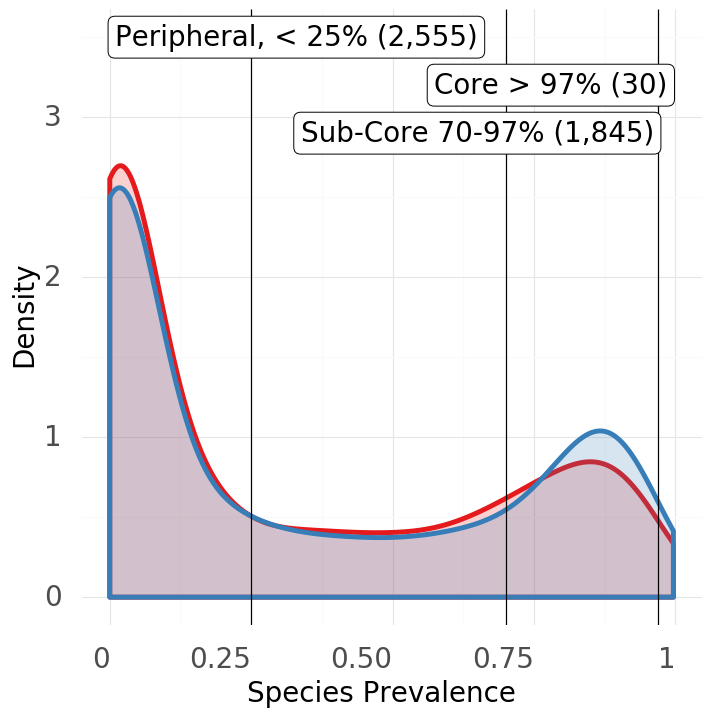

<ggplot: (8749278653802)>

In [10]:
def fig1_prevalence_curve(self):
    """Return a P9 figure showing the distribution of species prevalences."""
    t = self.wide_taxa.loc[self.meta['control_type'].isna()]
    prev = pd.DataFrame({
        'total': prevalence(t),
        'city': t.groupby(by=self.meta['city']).apply(prevalence).mean(axis=0),
    })
    n_periph = (prev['city'] < self.periph_thresh).sum()
    n_core = (prev['city'] > self.core_thresh).sum()
    n_sub_core = ((self.periph_thresh < prev['city']) & (prev['city'] < self.core_thresh)).sum()
    prev['taxa'] = prev.index
    prev_flat = prev.melt(id_vars='taxa')
    #return prev_flat
    plot = (
        ggplot(prev_flat, aes(x='value', color='variable', fill='variable')) +
            geom_density(size=2, alpha=0.2) +
            theme_minimal() +
            xlab('Species Prevalence') +
            ylab('Density') +
            geom_vline(xintercept=self.periph_thresh, color='black') +
            geom_vline(xintercept=self.sub_core_thresh, color='black') +
            geom_vline(xintercept=self.core_thresh, color='black') +
            annotate(geom='label', x=0.65, y=2.9, label=f"Sub-Core {int(100 * self.sub_core_thresh)}-{int(100 * self.core_thresh)}% ({n_sub_core:,})", size=20) +
            annotate(geom='label', x=0.33, y=3.5, label=f"Peripheral, < {int(100 * self.periph_thresh)}% ({n_periph:,})", size=20) +
            annotate(geom='label', x=0.78, y=3.2, label=f"Core > {int(100 * self.core_thresh)}% ({n_core:,})", size=20) +
            scale_color_brewer(type='qualitative', palette=6, direction=1) +
            scale_fill_brewer(type='qualitative', palette=6, direction=1) +
            theme(
                text=element_text(size=20),
                axis_text_x=element_text(angle=0, hjust=1),
                figure_size=(8, 8),
                legend_position='none',
            )
    )
    return plot

prev = fig1_prevalence_curve(figs)
prev

In [12]:
def fig1_prepare_taxa_ring(self):
    t = self.wide_taxa #.loc[self.meta['control_type'].isna()]
    t = (t > 0).groupby(self.meta['city']).mean()
    taxa_names = t.columns[t.mean() > self.core_thresh].to_series()
    taxa_names = taxa_names.rename({'Nocardioides sp. JS614': 'Nocardioides dokdonensis'})
    taxa_names = taxa_names.index.to_list()
    with open('metasub_core_taxa_tree.nwk', 'w') as f:
        t = TaxaTree(taxa_names, ncbi_tree=ncbi_tree).to_newick()
        t = t.replace('Brevundimonas_sp._GW460-12-10-14-LB2', 'Brevundimonas_sp._GW460')
        t = t.replace('Nocardioides sp. JS614', 'Nocardioides dokdonensis')
        f.write(t)

    core_taxa = md.annotate_taxa(taxa_names, drop=False)

    cols = ['biofilm_forming', 'human_commensal', 'gram_stain']
    core_taxa = core_taxa[cols]
    #return core_taxa
    core_taxa = core_taxa.rename(index={
        'Brevundimonas sp. GW460-12-10-14-LB2': 'Brevundimonas sp. GW460',
        'Nocardioides sp. JS614': 'Nocardioides dokdonensis',
    })
    core_taxa['taxa'] = core_taxa.index
    core_taxa = core_taxa.applymap(str)

    core_taxa.loc['Brevundimonas sp. GW460', 'gram_stain'] = 'Negative'
    core_taxa.loc['Cutibacterium acnes', 'human_commensal'] = 'Sometimes'

    core_taxa['biofilm_forming'] = core_taxa['biofilm_forming'].map(lambda v: 'Forms Films' if v == 'Always' else 'No Films')
    core_taxa['human_commensal'] = core_taxa['human_commensal'].map(lambda v: 'Commensal' if v in ['Maybe', 'Sometimes'] else 'Non-commensal')

    return core_taxa


core_taxa = fig1_prepare_taxa_ring(figs)
core_taxa

,biofilm_forming,human_commensal,gram_stain,taxa
Acinetobacter johnsonii,No Films,Commensal,Negative,Acinetobacter johnsonii
Actinomyces oris,Forms Films,Commensal,Positive,Actinomyces oris
Blastococcus saxobsidens,No Films,Commensal,Negative,Blastococcus saxobsidens
Brevundimonas naejangsanensis,No Films,Non-commensal,Negative,Brevundimonas naejangsanensis
Brevundimonas sp. GW460,No Films,Non-commensal,Negative,Brevundimonas sp. GW460
Cutibacterium acnes,No Films,Commensal,Positive,Cutibacterium acnes
Cutibacterium granulosum,No Films,Non-commensal,Positive,Cutibacterium granulosum
Dermacoccus nishinomiyaensis,No Films,Non-commensal,Positive,Dermacoccus nishinomiyaensis
Geodermatophilus obscurus,No Films,Commensal,Positive,Geodermatophilus obscurus
Janibacter indicus,No Films,Non-commensal,Positive,Janibacter indicus


In [13]:

core_taxa = figs.fig1_prepare_taxa_ring()

In [14]:
core_taxa.shape

(30, 4)

In [ ]:
%%R -i core_taxa -w 1920 -h 1920

library(ggthemes)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(RColorBrewer)
library(ggtree)

### Core tree METASUB 2019
## Author Maria A. Sierra

tree.core = read.newick("metasub_core_taxa_tree.nwk")
tree.core$tip.label = unlist(lapply(strsplit(tree.core$tip.label, "_"), FUN=function(x){paste0(x, collapse=" ")}))
rownames(core_taxa) = NULL
gt = ggtree(tree.core, layout="circular", open.angle=T, size=2) %<+% core_taxa +
        xlim(1,20) +
        geom_tiplab2(size=7.7, align = T, linetype=NA, colour="black", offset = 3.2, hjust = 0) +
        labs(color='Phylum')

# Heatmap ring
ring = core_taxa[,c('human_commensal', 'gram_stain','biofilm_forming')]
colnames(ring) = c('Human Commensal', 'Gram Stain', 'Forms Biofilms')
rownames(ring) = core_taxa$taxa
gt = gheatmap(gt, ring, offset=0, width=0.27, font.size=7, colnames_offset_y=6, colnames_angle=90, colnames_position="top", hjust = 1)+
  scale_fill_brewer(palette = "Paired", na.value="gray90", direction=-1) +
  theme_tree(
      text = element_text(size=100),
      legend.position="right", 
      legend.text = element_text(colour="gray30", size = 26), 
      legend.title=element_text(size = 30),
      legend.key.size=unit(2,"line")
  ) + 
  guides(colour=guide_legend(override.aes=list(size=5)), fill=guide_legend(ncol=2)) +
  labs(fill = "Commensal  Gram-Stain Forms Biofilms")

ggsave('f_1_a.jpg')
gt

In [ ]:
f1b = figs.fig1_prevalence_curve()
f1b.save('figs/fig_1_b.pdf', dpi=300)

f1b

In [ ]:
f1c = list(figs.fig1_major_taxa_curves())
f1c[0].save('figs/fig_1_c_1.pdf', dpi=300, limitsize=False)
f1c[1].save('figs/fig_1_c_2.pdf', dpi=300, limitsize=False)
f1c

In [ ]:
f1d = figs.fig1_species_rarefaction()
f1d.save('figs/fig_1_d.pdf', dpi=300, limitsize=False)
f1d

In [ ]:
f1e = figs.fig1_reference_comparisons()
f1e[0].save('figs/fig_1_e.pdf', dpi=300, limitsize=False)
f1e[1].save('figs/fig_1_f.pdf', dpi=300, limitsize=False)

f1e

In [ ]:
figs.fig1_fraction_unclassified()

In [ ]:
f2a = figs.fig2_umap()
f2a.save('fig_2_a.svg', dpi=300, limitsize=False)

f2a

In [ ]:
f2c, f2d, f2e = figs.fig2_region_blocks()

f2c.save('figs/fig_2_c.pdf', dpi=300, limitsize=False)
f2d.save('figs/fig_2_d.pdf', dpi=300, limitsize=False)

[f2c, f2d, f2e]

In [ ]:
figs.taxa_sample_order

In [ ]:
lat = pd.DataFrame(figs.meta.loc[figs.taxa_sample_order]['latitude'].map(abs))
lat = lat.dropna()
lat['X'] = range(lat.shape[0])

(
    ggplot(lat, aes(x='X', y='latitude')) +
        geom_point() +
        geom_smooth(color='red') +
        ylim(0, 64) +
        ylab('Absolute Latitude') +
        xlab('Samples ordered according to Heirarchical Clustering of Taxa')
)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


alpha_lm = ols('latitude ~ X', data=lat).fit()
print(sm.stats.anova_lm(alpha_lm, typ=2))
print(alpha_lm.summary())

In [ ]:
f2b = figs.fig2_pca_flows()

for i, el in enumerate(f2b):
    el.save(f'fig_2_b_{i}.svg', dpi=300, limitsize=False)
    
f2b

In [ ]:
figs.fig2_pca_flows_amr()

In [ ]:
f4d = figs.fig5_amr_cooccur()

#f4d[0].savefig('fig_4_d_1.jpg', dpi=300)
#f4d[1].savefig('fig_4_d_2.jpg', dpi=300)
len(f4d)

In [ ]:

f4c = figs.fig5_amr_richness_by_city()
f4c.save('fig_4_c.svg', dpi=300)

f4c

In [ ]:
figs.fig5_amr_rarefaction()

In [ ]:

f1g = figs.fig_fraction_assigned()
f1g.save('figs/fig_1_g.pdf', dpi=300)
f1g

In [ ]:
figs.fraction_assigned.query('percent_id == "80"').groupby('variable').mean()

In [ ]:

figs.fig4_city_accuracy()


In [ ]:
figs.fig4_city_accuracy(n_classifiers=100)


In [ ]:
figs.fig4_city_accuracy(n_classifiers=10)

In [ ]:
figs.fig4_city_accuracy(n_classifiers=1000)

In [ ]:

figs.fig4_prediction_hmap()


In [ ]:

figs.fig4_prediction_hmap_null()


In [ ]:



figs.fig4_escores_city()

In [ ]:
list(figs.meta.columns)

figs.fig4_escores_city(grp='surface_ontology_fine')

In [ ]:

figs.fig4_escores()


In [ ]:

f4a, f5b = figs.fig5_amr_class()


In [ ]:
figs.fig5_amr_mech()

In [ ]:
figs.fig5_city_amr_accuracy()

In [ ]:
figs.city_classification_random_accuracy()

In [ ]:
figs.amr_depth()

In [ ]:
figs.fig_fraction_assigned_continent()

In [ ]:
def fig_fraction_assigned_ani80_continent(self):
    tbl = self.fraction_assigned
    tbl = tbl.query('percent_id == "80"')
    return (
        ggplot(tbl, aes(x='variable', y='value', fill='continent')) +
            geom_boxplot() +
            # facet_grid('.~continent', scales='free_x') +
            theme_minimal() +
            #scale_y_sqrt() +
            ylim(0, 1) +
            scale_fill_brewer(type='qualitative', palette=6, direction=1) +
            xlab('') +
            ylab('Fraction of Reads Aligned') +
            labs(fill='Percent ANI') +
            theme(
                text=element_text(size=20),
                figure_size=(24, 8),
                legend_position='right',
                axis_text_x=element_text(angle=90),
                panel_border=element_rect(colour="black", size=2),
            )
    )

fig_fraction_assigned_ani80_continent(figs)

In [ ]:
figs.fig2_umap(color='city', color_pal=labs(color='City')) + theme(
    legend_position='right',
    text=element_text(size=15),
    figure_size=(16, 16)
)

In [ ]:

figs.fig2_umap(color='climate', color_pal=labs(color='Climate')) + theme(
    legend_position='right',
    text=element_text(size=15),
    figure_size=(16, 16)
)

In [ ]:
figs.fig_amr_taxa_richness_correlation()

In [ ]:

figs.fig_city_sigs()


In [ ]:

figs.amr_by_region()

In [ ]:

figs.fig_surface_hmp()

In [ ]:
def fig_surface_hmp_data(self):
    hmp = self.hmp
    hmp['surface'] = [self.meta.loc[sn]['surface'] for sn in hmp['sample_name']]
    hmp = hmp.query('surface != "NaN"')
    hmp = hmp.query('surface != "Nan"')
    hmp = hmp.query('surface != "air"')
    hmp = hmp.query('surface != "negative control"')
    hmp = hmp.query('surface != "bed headboard"')
    hmp = hmp.query('surface != "playground"')
    hmp = hmp.query('surface != "entrance_door"')
    hmp['body_site'] = hmp['body_site'].map(to_title)
    hmp['surface'] = hmp['surface'].map(normalize_surface).map(to_title)
    n_samps = hmp['surface'].value_counts() / 50
    allowed_surfaces = set(n_samps[n_samps >= 8].index)
    hmp = hmp.loc[hmp['surface'].isin(allowed_surfaces)]
    surface_order = hmp.query('body_site == "Skin"').groupby('surface').median()
    surface_order = list(surface_order.sort_values('jaccard').index)
    hmp['surface'] = pd.Categorical(hmp['surface'], categories=surface_order)
    hmp['body_site'] = pd.Categorical(hmp['body_site'], categories=[
        'Skin',
        'Airways',
        'Oral',
        'Urogenital',
        'Gastrointestinal',
    ])
    hmp = hmp.query('surface != "Nan"')
    return hmp

data = fig_surface_hmp_data(figs)

In [ ]:
data = data.query('body_site == "Skin"')
ttest_ind(
    data.query('surface == "Door Knob"')['jaccard'],
    data.query('surface == "Window"')['jaccard'],
)

In [ ]:
ttest_ind(
    data.query('surface == "Touchscreen"')['jaccard'],
    data.query('surface == "Seat"')['jaccard'],
)

In [ ]:
ttest_ind(
    data.query('surface == "Railing"')['jaccard'],
    data.query('surface == "Table"')['jaccard'],
)

In [ ]:

figs.fig_surface_hmp_region()

In [ ]:

figs.fig_surface_umap()

In [ ]:

    def leave_one_city_out(self):
        TAXA = self.wide_taxa_rel

        COLS = [
            'city',
            'coastal_city', 'city_total_population', 'city_population_density', 
            'city_ave_june_temp_c', 'continent', 'city_koppen_climate',  
            'surface_ontology_fine', 'surface_ontology_coarse', 'city_elevation'
        ]
        METADATA = self.meta[COLS]
        METADATA['city_ave_june_temp_c'] = pd.cut(METADATA['city_ave_june_temp_c'], 3, labels=['low', 'medium', 'high'])
        METADATA['city_population_density'] = pd.cut(METADATA['city_population_density'], 3, labels=['low', 'medium', 'high'])
        METADATA['city_total_population'] = pd.cut(METADATA['city_total_population'], 3, labels=['low', 'medium', 'high'])

        def prep_data(feature_to_predict):
            train_taxa = TAXA.copy()
            train_feature = METADATA.loc[TAXA.index, feature_to_predict]
            feature, name_map = pd.factorize(feature)
            return train_taxa, train_feature, name_map, test_names

        def train_test_model(feature_to_predict):
            train_taxa, train_feature, name_map, test_names = prep_data(feature_to_predict)
            classifier = RandomForestClassifier(n_estimators=100, random_state=0)
            classifier.fit(train_taxa, train_feature)
            return classifier
        
            predictions = classifier.predict(test_taxa).round()
            confidences = [0] * len(predictions) # np.max(classifier.predict_proba(test_taxa), axis=1)
            assert len(predictions) == len(confidences)

            predictions = [name_map[el] for el in predictions]
            actual = [name_map[el] for el in test_feature]

            return pd.DataFrame([{
                    'uuid': test_names[i],
                    'predicted': predictions[i],
                    'confidence': confidences[i],
                    'actual': actual[i],
                    'city': leave_out_city,
                    'feature': feature_to_predict,
                } 
                for i in range(len(predictions))
            ])
        
        result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)

        tbls = []
        for city in self.meta.loc[TAXA.index, 'city'].unique():
            if city in ['other', 'tsuruoka']:
                continue
            print(city)
            for feature in COLS:
                if feature in ['city']:
                    continue
                tbls.append(train_test_model((city, feature)))
        tbl = pd.concat(tbls)
        return tbl


In [ ]:
TAXA = figs_data.wide_taxa_rel

COLS = [
    'city',
    'coastal_city', 'city_total_population', 'city_population_density', 
    'city_ave_june_temp_c', 'continent', 'city_koppen_climate',  
    'surface_ontology_fine', 'surface_ontology_coarse', 'city_elevation'
]
METADATA = figs_data.meta[COLS]
METADATA['city_ave_june_temp_c'] = pd.cut(METADATA['city_ave_june_temp_c'], 3, labels=['low', 'medium', 'high'])
METADATA['city_population_density'] = pd.cut(METADATA['city_population_density'], 3, labels=['low', 'medium', 'high'])
METADATA['city_total_population'] = pd.cut(METADATA['city_total_population'], 3, labels=['low', 'medium', 'high'])

def prep_data(feature_to_predict):
    train_taxa = TAXA.copy()
    train_feature = METADATA.loc[TAXA.index, feature_to_predict]
    feature, name_map = pd.factorize(train_feature)
    return train_taxa, train_feature, name_map, feature

def train_test_model(train_taxa, train_feature, name_map, feature):
    classifier = RandomForestClassifier(n_estimators=100, random_state=0)
    classifier.fit(train_taxa, feature)
    return classifier

In [ ]:
train_taxa, train_feature, name_map, feature = prep_data('coastal_city')
rf_coast = train_test_model(train_taxa, train_feature, name_map, feature)
coast_taxa = TAXA.columns[rf_coast.feature_importances_.argsort()[::-1]][:100]
coast_taxa[:10]

In [ ]:
train_taxa, train_feature, name_map, feature = prep_data('city_total_population')
rf_pop = train_test_model(train_taxa, train_feature, name_map, feature)
pop_taxa = TAXA.columns[rf_pop.feature_importances_.argsort()[::-1]][:100]
pop_taxa[:10]

In [ ]:
train_taxa, train_feature, name_map, feature = prep_data('city_population_density')
rf_pop_den = train_test_model(train_taxa, train_feature, name_map, feature)
pop_den_taxa = TAXA.columns[rf_pop_den.feature_importances_.argsort()[::-1]][:100]
pop_den_taxa[:10]

In [ ]:
train_taxa, train_feature, name_map, feature = prep_data('city_total_population')
pop = TAXA[pop_taxa[:10]].groupby(train_feature).mean()
#pop.index = ['low', 'medium', 'high']
pop /= pop.sum()
pop['kind'] = pop.index

pop = pop.melt(id_vars='kind')
pop

(
    ggplot(pop, aes(x='kind', y='taxa_name', fill='value')) +
        geom_tile() +
        theme_minimal() +
        ylab('') +
        xlab('City Population') +
        theme(
            text=element_text(size=20),
            figure_size=(8, 8),
            #legend_position='none',
            axis_text_x=element_text(angle=90),
        )
)

In [ ]:
train_taxa, train_feature, name_map, feature = prep_data('city_population_density')
pop = TAXA[pop_den_taxa[:30]].groupby(train_feature).mean()
#pop.index = ['low', 'medium', 'high', 'very-high']
pop /= pop.sum()
pop['kind'] = pop.index

pop = pop.melt(id_vars='kind')
pop

(
    ggplot(pop, aes(x='kind', y='taxa_name', fill='value')) +
        geom_tile() +
        theme_minimal() +
        ylab('') +
        xlab('City Population Density') +
        theme(
            text=element_text(size=20),
            figure_size=(8, 12),
            #legend_position='none',
            axis_text_x=element_text(angle=90),
        )
)

In [ ]:
train_taxa, train_feature, name_map, feature = prep_data('city_population_density')
pop = TAXA[pop_den_taxa[:30]]  #.groupby(METADATA['city']).mean()]
pop *= 1000 * 1000
pop['city'] = [METADATA.loc[s, 'city'] for s in pop.index]
pop['kind'] = train_feature
#pop.index = ['low', 'medium', 'high', 'very-high']
# pop /= pop.sum()
# pop['kind'] = pop.index
pop = pop.dropna()
pop = pop.melt(id_vars=['city', 'kind'])
pop = pop.query('taxa_name == "Rubrobacter xylanophilus"')
pop

(
    ggplot(pop, aes(x='kind', y='value', fill='kind')) +
        #facet_grid('.~kind', scales='free') +
        geom_boxplot() +
        theme_minimal() +
        ylab('Abundance (PPM)') +
        xlab('City Population Density') +
        scale_y_log10() +
        ggtitle('Rubrobacter xylanophilus') +
        theme(
            text=element_text(size=20),
            figure_size=(12, 8),
            #legend_position='none',
            axis_text_x=element_text(angle=00),
        )
)

In [ ]:
train_taxa, train_feature, name_map, feature = prep_data('city_population_density')
pop = TAXA[pop_den_taxa[:30]]  #.groupby(METADATA['city']).mean()]
pop *= 1000 * 1000
pop['city'] = [METADATA.loc[s, 'city'] for s in pop.index]
pop['kind'] = train_feature
#pop.index = ['low', 'medium', 'high', 'very-high']
# pop /= pop.sum()
# pop['kind'] = pop.index
pop = pop.dropna()
pop = pop.melt(id_vars=['city', 'kind'])
pop = pop.query('taxa_name == "Acinetobacter junii"')
pop

(
    ggplot(pop, aes(x='kind', y='value', fill='kind')) +
        #facet_grid('.~kind', scales='free') +
        geom_boxplot() +
        theme_minimal() +
        ylab('Abundance (PPM)') +
        xlab('City Population Density') +
        scale_y_log10() +
        ggtitle('Acinetobacter junii') +
        theme(
            text=element_text(size=20),
            figure_size=(12, 8),
            #legend_position='none',
            axis_text_x=element_text(angle=00),
        )
)

In [ ]:
train_taxa, train_feature, name_map, feature = prep_data('coastal_city')
pop = TAXA[coast_taxa[:30]].groupby(train_feature).mean()
#pop.index = ['low', 'medium', 'high', 'very-high']
pop /= pop.sum()
pop['kind'] = pop.index

pop = pop.melt(id_vars='kind')
pop

(
    ggplot(pop, aes(x='kind', y='taxa_name', fill='value')) +
        geom_tile() +
        theme_minimal() +
        ylab('') +
        xlab('Coastal City') +
        theme(
            text=element_text(size=20),
            figure_size=(8, 12),
            #legend_position='none',
            axis_text_x=element_text(angle=90),
        )
)

In [ ]:
train_feature


In [ ]:
name_map

In [ ]:
def normalize_control(el):
    return {
        'tube & rna/dna out & swab': 'negative_control',
        'tube & rna/dna out': 'negative_control',
        'poszymo': 'positive_control',
        'dry tube': 'negative_control',
        'dry tube & swab': 'negative_control',
        'ctrl cities': 'background_control',
    }.get(el, el)


def control(self):
    ctrls = self.meta.query('control_type == control_type')
    return ctrls
    ctrl_taxa = self.wide_taxa_rel.loc[ctrls.index]
    return ctrl_taxa.loc[:, (ctrl_taxa > 0).sum() >= 2]

control(figs)['control_type'].unique()

In [ ]:


def control_prevalence(self):
    ctrls = self.meta.query('control_type == control_type')
    ctrls['control_type'] = ctrls['control_type'].map(normalize_control).map(to_title)
    ctrl_taxa = self.wide_taxa_rel.loc[ctrls.index]
    ctrl_taxa = ctrl_taxa.loc[:, (ctrl_taxa > 0).sum() > 0]
    
    def get_prev(sample_names):
        ctrl_prev = (ctrl_taxa.loc[sample_names] > 0).mean()
        return ctrl_prev
    
    tbl = {}
    for kind in ['All', 'Negative Control', 'Positive Control', 'Background Control']:
        sample_names = ctrls.index
        if kind != 'All':
            sample_names = ctrls.query('control_type == @kind').index
        tbl[kind.split()[0] + f' ({len(sample_names)})'] = get_prev(sample_names)
 
    ctrl_prev = pd.DataFrame.from_dict(tbl, orient='columns')
    ctrl_prev = ctrl_prev.melt()
    return (
        ggplot(ctrl_prev, aes(x='value')) +
            geom_histogram() +
            facet_grid('variable~.', scales='free_x') +
            theme_minimal() +
            ylab('Number of Taxa') +
            xlab('Fraction of Control Samples')+
            #scale_fill_brewer(type='qualitative', palette=6, direction=1) +
            #labs(color="continent") +
            theme(
                #axis_text_x=element_text(angle=90, hjust=0.5),
                text=element_text(size=16),
                legend_position='none',
                figure_size=(8, 12),
                panel_border=element_rect(colour="black", fill='none', size=1),
            )  
    )

control_prevalence(figs)

In [ ]:
def control_abundance(self):
    ctrls = self.meta.query('control_type == control_type')
    ctrls['control_type'] = ctrls['control_type'].map(normalize_control).map(to_title)
    ctrl_taxa = self.wide_taxa_rel.loc[ctrls.index]
    ctrl_taxa = ctrl_taxa.loc[:, (ctrl_taxa > 0).sum() > 0]
    ctrl_taxa = ctrl_taxa.fillna(0)

    nbins, bin_width = 10, 0.01
    taxa_max = ctrl_taxa.max().max()
    taxa_max = int(taxa_max / bin_width + 0.5)
    cut_range = [el * bin_width for el in range(0, taxa_max + 1)]
    cut_range = [0, 10 ** -6, 10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 1]
    def get_abundance(sample_names):
        abund = ctrl_taxa.loc[sample_names].mean()
        abund = pd.cut(abund, cut_range, include_lowest=True)
        return abund
    
    tbl = {}
    for kind in ['All', 'Negative Control', 'Positive Control', 'Background Control']:
        sample_names = ctrls.index
        if kind != 'All':
            sample_names = ctrls.query('control_type == @kind').index
        tbl[kind.split()[0] + f' ({len(sample_names)})'] = get_abundance(sample_names)
 
    ctrl_prev = pd.DataFrame.from_dict(tbl, orient='columns')
    ctrl_prev = ctrl_prev.melt()
    return (
        ggplot(ctrl_prev, aes(x='value')) +
            geom_histogram() +
            facet_grid('variable~.', scales='free_x') +
            theme_minimal() +
            scale_y_log10() +
            ylab('Number of Taxa') +
            xlab('Mean Taxa Abundance')+
            #scale_fill_brewer(type='qualitative', palette=6, direction=1) +
            #labs(color="continent") +
            theme(
                axis_text_x=element_text(angle=90, hjust=0.5),
                text=element_text(size=16),
                legend_position='none',
                figure_size=(8, 12),
                panel_border=element_rect(colour="black", fill='none', size=1),
            )  
    )

control_abundance(figs)

In [ ]:
def control_abundance(self):
    ctrls = self.meta.query('control_type == control_type')
    ctrl_taxa = self.wide_taxa_rel.loc[ctrls.index]
    ctrl_taxa = ctrl_taxa.loc[:, (ctrl_taxa > 0).sum() > 0]
    ctrl_taxa = ctrl_taxa.fillna(0)

    nbins, bin_width = 10, 0.01
    taxa_max = ctrl_taxa.max().max()
    taxa_max = int(taxa_max / bin_width + 0.5)
    cut_range = [el * bin_width for el in range(0, taxa_max + 1)]
    cut_range = [0, 10 ** -6, 10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 1]
    def get_abundance(sample_names):
        abund = ctrl_taxa.loc[sample_names].mean()
        abund = pd.cut(abund, cut_range, include_lowest=True)
        return abund
    
    tbl = {}
    for kind in ['All', 'Negative Control', 'Positive Control', 'Background Control']:
        sample_names = ctrls.index
        if kind != 'All':
            sample_names = ctrls.query('control_type == @kind').index
        tbl[kind.split()[0] + f' ({len(sample_names)})'] = get_abundance(sample_names)
 
    ctrl_prev = pd.DataFrame.from_dict(tbl, orient='columns')
    ctrl_prev = ctrl_prev.melt()
    return (
        ggplot(ctrl_prev, aes(x='value')) +
            geom_histogram() +
            facet_grid('variable~.', scales='free_x') +
            theme_minimal() +
            scale_y_log10() +
            ylab('Number of Taxa') +
            xlab('Mean Taxa Abundance')+
            #scale_fill_brewer(type='qualitative', palette=6, direction=1) +
            #labs(color="continent") +
            theme(
                axis_text_x=element_text(angle=90, hjust=0.5),
                text=element_text(size=16),
                legend_position='none',
                figure_size=(8, 12),
                panel_border=element_rect(colour="black", fill='none', size=1),
            )  
    )

In [ ]:

def bar(self, taxon='Cutibacterium acnes'):
    taxon = self.long_taxa.query('taxa_name == @taxon')
    return self.meta.loc[taxon['sample']]['control_type'].map(normalize_control).fillna('case').unique()

bar(figs)

In [ ]:
def bar(self, taxon='Cutibacterium acnes'):
    taxon = self.long_taxa.query('taxa_name == @taxon')
    taxon['control_type'] = list(self.meta.loc[taxon['sample']]['control_type'].map(normalize_control))
    taxon['control_type'] = taxon['control_type'].fillna('Case')
    return taxon

tbl = bar(figs)

In [ ]:
(
    ggplot(bar(figs), aes(x='kmers', color='control_type')) +
        geom_density(size=2) +
        ggtitle(taxon)

)

In [ ]:

def bar(self, taxa_names=['Cutibacterium acnes', 'Bradyrhizobium sp. BTAi1']):
    tbls = []
    for taxa_name in taxa_names:
        taxon = self.long_taxa.query('taxa_name == @taxa_name')
        taxon = taxon.query('kmers > 0')
        taxon['control_type'] = list(self.meta.loc[taxon['sample']]['control_type'].map(normalize_control))
        taxon['control_type'] = taxon['control_type'].fillna('Case')
        tbls.append(taxon)
    taxon = pd.concat(tbls)
    return (
        ggplot(taxon, aes(x='kmers', color='control_type', fill='control_type')) +
            geom_density(size=1, alpha=0.2) +
            facet_grid('taxa_name~.', scales='free') +
            labs(fill='Control Type', color='Control Type') +
            ylab('Density') +
            xlab('Num. Unique K-Mers') +
            theme_minimal() +
            scale_y_sqrt() +
            scale_x_log10() +
            theme(
                text=element_text(size=16),
                figure_size=(8, 3.5 * len(taxa_names)),
                panel_border=element_rect(colour="black", fill='none', size=1),
            )  
            

    )


bar(figs, taxa_names=[
    'Cutibacterium acnes',
    'Bradyrhizobium sp. BTAi1',
    'Micrococcus luteus',
    'Pseudomonas stutzeri',
    'Moraxella osloensis',
])

In [ ]:
bar(figs, taxa_name='Bradyrhizobium sp. BTAi1') + scale_y_sqrt()

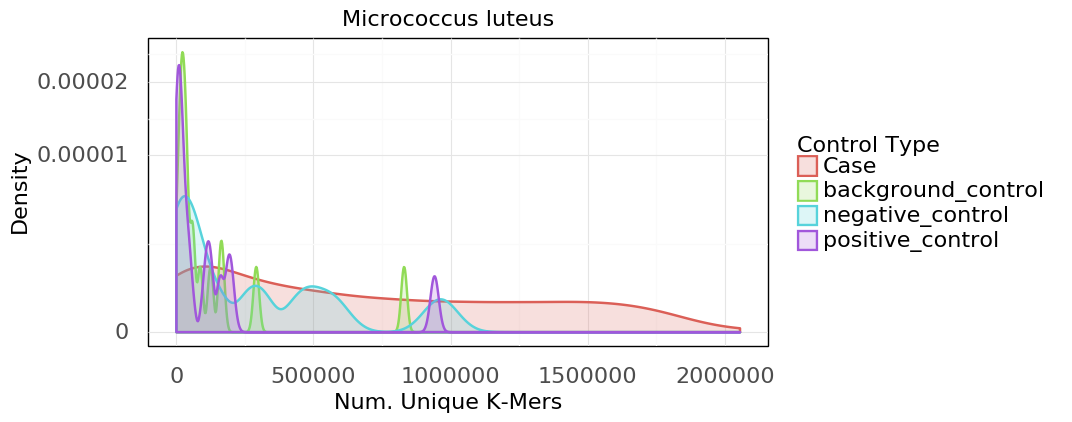

<ggplot: (8739943965767)>

In [146]:
bar(figs, taxa_name='Micrococcus luteus') + scale_y_sqrt()

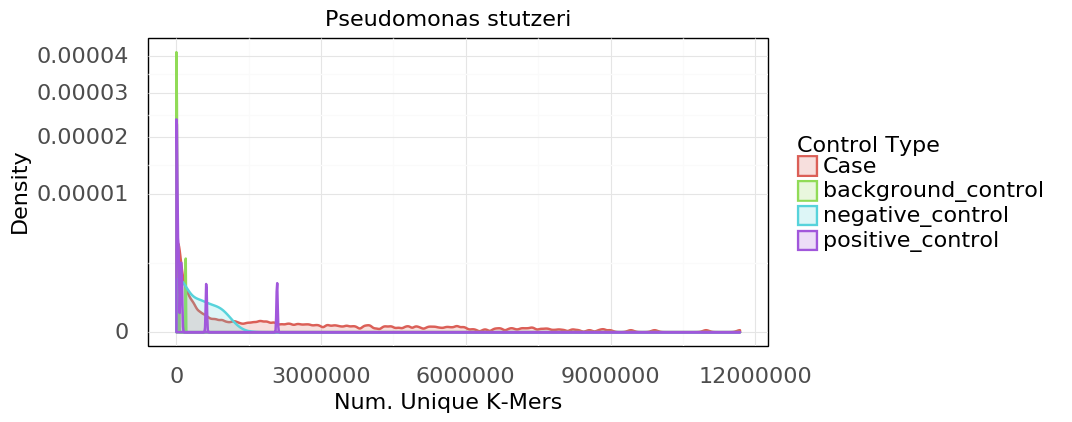

<ggplot: (-9223363296902637831)>

In [147]:
bar(figs, taxa_name='Pseudomonas stutzeri') + scale_y_sqrt()

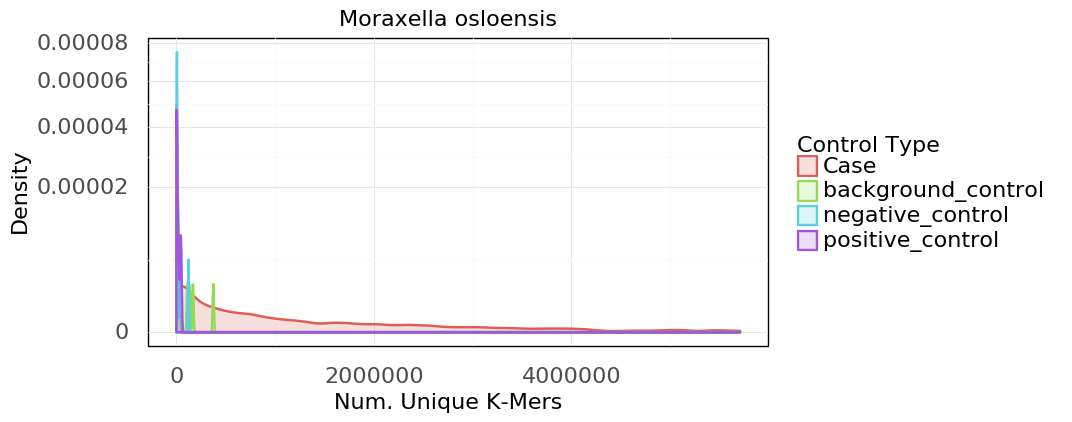

<ggplot: (-9223363296910709069)>

In [148]:
bar(figs, taxa_name='Moraxella osloensis') + scale_y_sqrt()

In [72]:


def foo(self):
    ctrls = self.meta.query('control_type == control_type')
    ctrls['control_type'] = ctrls['control_type'].map(normalize_control)
    long_ctrls = self.long_taxa['sample'].isin(ctrls.index)
    long_ctrls = self.long_taxa.loc[long_ctrls]
    long_ctrls['control_type'] = list(ctrls.loc[long_ctrls['sample']]['control_type'])
    # long_ctrls = long_ctrls.groupby(('control_type', 'taxa_name'), as_index=False).quantile(0.8)
    
    cases = self.meta.query('control_type != control_type')
    long_cases = self.long_taxa['sample'].isin(cases.index)
    long_cases = self.long_taxa.loc[long_cases]

    def _case_control_ratio(kind, col):
        """Return a dataframe giving the ratiobetween cases and controls for the given value."""
        my_ctrls = long_ctrls.query('control_type == @kind')
        my_ctrl_maxes = my_ctrls[['taxa_name', col]].groupby('taxa_name').quantile(0.95)
        long_cases[f'control__{col}__{kind}'] = list(my_ctrl_maxes.loc[long_cases['taxa_name']][col])
        long_cases[f'ratio__{col}__{kind}'] = long_cases[col] / long_cases[f'control__{col}__{kind}']
        return long_cases
    
    ratio_cases = _case_control_ratio('negative_control', 'kmers')
    ratio_cases = _case_control_ratio('negative_control', 'kmer_read_ratio')          
    return ratio_cases

ratioed = foo(figs)
ratioed

,sample,taxa_name,taxa_id,rank,mpa,reads,kmers,dup,cov,percent,tax_reads,kmer_read_ratio,control__kmers__negative_control,ratio__kmers__negative_control,control__kmer_read_ratio__negative_control,ratio__kmer_read_ratio__negative_control
282385,haib17CEM4890_H2NYMCCXY_SL254769,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,399,43972,1.51,0.010620,0.001612,383,110.205514,3087566.75,0.014242,135.955878,0.810598
282386,haib17CEM4890_H2NYMCCXY_SL254769,Cutibacterium avidum,33010,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,15,268,6.69,0.000066,0.000061,6,17.866667,14460.20,0.018534,74.415672,0.240093
282387,haib17CEM4890_H2NYMCCXY_SL254769,Cutibacterium granulosum,33011,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,43,1446,2.72,0.000703,0.000174,0,33.627907,126970.00,0.011389,83.743398,0.401559
282388,haib17CEM4890_H2NYMCCXY_SL254770,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,688,77642,1.54,0.018750,0.002356,670,112.851744,3087566.75,0.025147,135.955878,0.830062
282389,haib17CEM4890_H2NYMCCXY_SL254770,Cutibacterium avidum,33010,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,51,644,2.05,0.000159,0.000175,22,12.627451,14460.20,0.044536,74.415672,0.169688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37772082,haib18CEM5453_HMGN5CCXY_SL344669,Cotton leaf curl Multan virus satellite U36-1,260479,species,s__Cotton_leaf_curl_Multan_virus_satellite_U36-1,9,105,4.34,0.094680,0.000430,0,11.666667,NaN,NaN,NaN,NaN
37772083,haib18CEM5453_HMGW3CCXY_SL342346,Cotton leaf curl Multan virus satellite U36-1,260479,species,s__Cotton_leaf_curl_Multan_virus_satellite_U36-1,8,173,2.45,0.156000,0.000263,0,21.625000,NaN,NaN,NaN,NaN
37772084,haib18CEM5453_HNGH3CCXY_SL344520,Cotton leaf curl Multan virus satellite U36-1,260479,species,s__Cotton_leaf_curl_Multan_virus_satellite_U36-1,8,66,2.44,0.059510,0.000208,0,8.250000,NaN,NaN,NaN,NaN
37772104,haib18CEM5453_HNGH3CCXY_SL344533,Cotton leaf curl Gezira alphasatellite,679536,species,s__Cotton_leaf_curl_Gezira_alphasatellite,4,317,1.52,0.299300,0.000092,0,79.250000,NaN,NaN,NaN,NaN


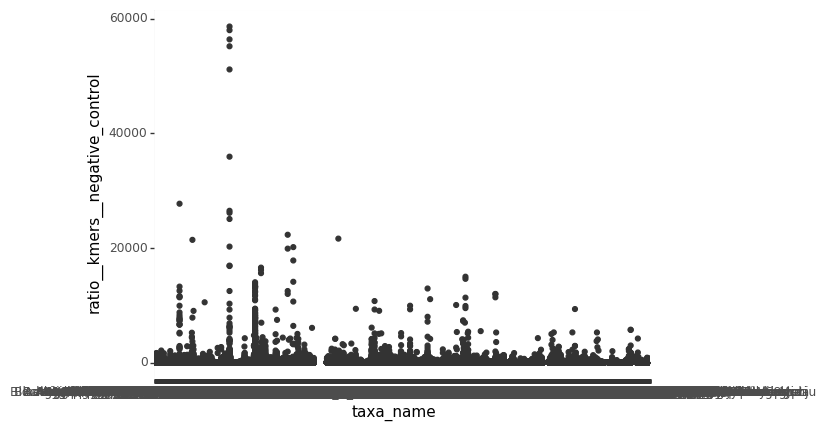

<ggplot: (-9223363296901723013)>

In [73]:
(
    ggplot(ratioed, aes(x='taxa_name', y='ratio__kmers__negative_control')) +
        geom_boxplot()
)

In [90]:

def thresh(t):
    more_kmers_than_ncs = ratioed.groupby('taxa_name').apply(
        lambda tbl: (tbl['ratio__kmers__negative_control'].map(
            lambda val: str(val).lower() == 'nan' or val > t)
        ).mean()
    )
    return more_kmers_than_ncs
more_kmers_than_ncs = pd.DataFrame({
    '0.5': thresh(0.5),
    '1': thresh(1),
    '2': thresh(2),
    '4': thresh(4),
})
more_kmers_than_ncs

,0.5,1,2,4
taxa_name,,,,
Acanthamoeba polyphaga mimivirus,1.000000,1.000000,1.000000,1.000000
Acaryochloris marina,1.000000,1.000000,1.000000,1.000000
Acetoanaerobium sticklandii,1.000000,1.000000,1.000000,1.000000
Acetobacter aceti,0.870316,0.615836,0.323232,0.108504
Acetobacter pasteurianus,0.797074,0.562977,0.336196,0.180662
...,...,...,...,...
methanogenic archaeon ISO4-H5,1.000000,1.000000,1.000000,1.000000
secondary endosymbiont of Ctenarytaina eucalypti,1.000000,1.000000,1.000000,1.000000
secondary endosymbiont of Heteropsylla cubana,1.000000,1.000000,1.000000,1.000000


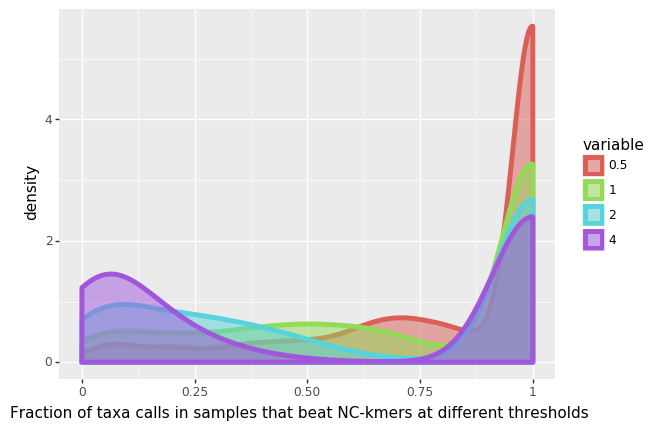

<ggplot: (8739921310833)>

In [94]:
pd.DataFrame(more_kmers_than_ncs)

(
    ggplot(more_kmers_than_ncs.melt(), aes(x='value', color='variable', fill='variable')) +
        geom_density(size=2, alpha=0.5) +
        xlab('Fraction of taxa calls in samples that beat NC-kmers at different thresholds')
)

In [67]:

def foo2(self):
    ctrls = self.meta.query('control_type == control_type')
    cases = self.meta.query('control_type != control_type')
    rich = (self.wide_taxa > 0).sum(axis=1)
    rich = pd.DataFrame(rich)
    rich.columns = ['richness']
    rich['read_count'] = self.wide_taxa.sum(axis=1)
    rich['control_type'] = self.meta['control_type'].map(normalize_control).fillna('case').map(to_title)
    return rich

rich = foo2(figs)
rich

,richness,read_count,control_type
sample,,,
haib17CEM4890_H2NYMCCXY_SL254769,1136,2703512.0,Case
haib17CEM4890_H2NYMCCXY_SL254770,1631,4335868.0,Case
haib17CEM4890_H2NYMCCXY_SL254771,1528,3432339.0,Case
haib17CEM4890_H2NYMCCXY_SL254772,1390,1179017.0,Case
haib17CEM4890_H2NYMCCXY_SL254773,2276,866791.0,Case
...,...,...,...
sossowski_BarcelonaNov2018_CSD16-BCN-258-29786-GGACTCCT-TATCCTCT,842,270626.0,Case
sossowski_BarcelonaNov2018_CSD16-BCN-259-29787-GGACTCCT-GTAAGGAG,507,89103.0,Case
sossowski_BarcelonaNov2018_CSD16-BCN-261-29787-GGACTCCT-AAGGAGTA,964,647306.0,Case


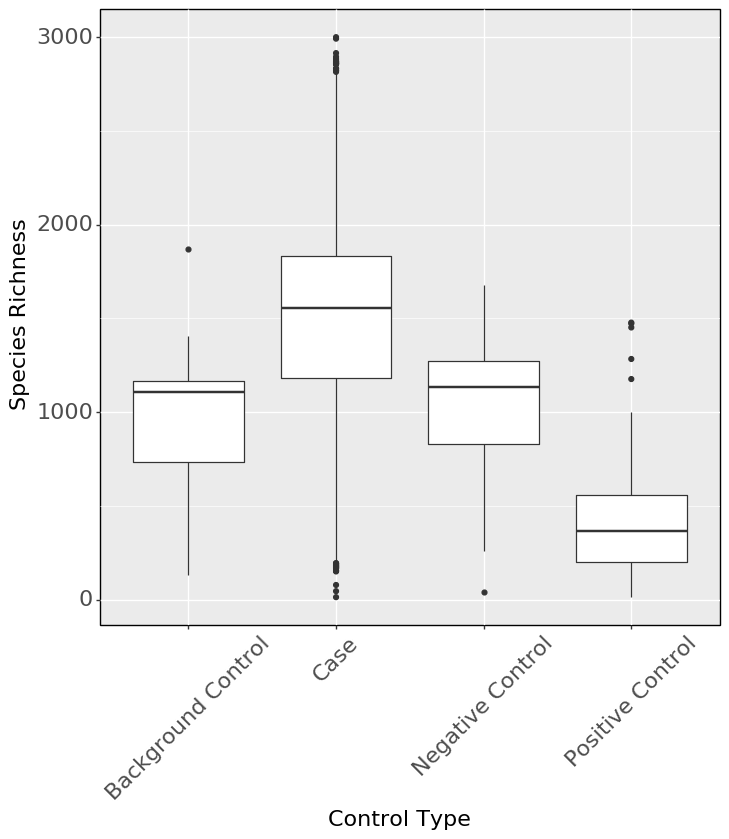

<ggplot: (-9223363296902503950)>

In [170]:
(
    ggplot(rich, aes(x='control_type', y='richness')) +
        geom_boxplot() +
        xlab('Control Type') +
        ylab('Species Richness') +
        theme(
            text=element_text(size=16),
            axis_text_x=element_text(angle=45, hjust=-1),
            figure_size=(8, 8),
            panel_border=element_rect(colour="black", fill='none', size=1),
        )  
)

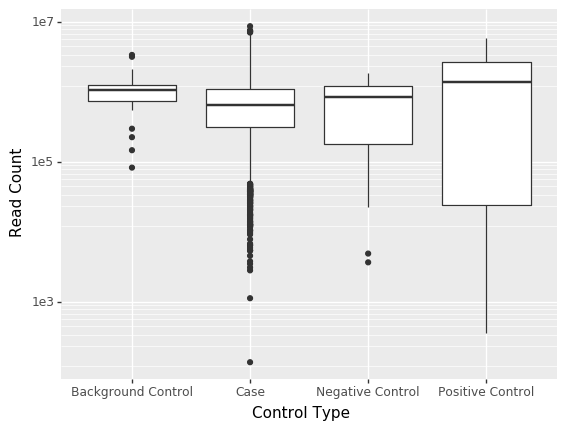

<ggplot: (-9223363296899178124)>

In [70]:
(
    ggplot(rich, aes(x='control_type', y='read_count')) +
        geom_boxplot() +
        xlab('Control Type') +
        ylab('Read Count') +
        scale_y_log10()
)

In [42]:
def get_ctrls(self):
    ctrls = self.meta.query('control_type == control_type')
    ctrls['control_type'] = ctrls['control_type'].map(normalize_control)
    long_ctrls = self.long_taxa['sample'].isin(ctrls.index)
    long_ctrls = self.long_taxa.loc[long_ctrls]
    long_ctrls['control_type'] = list(ctrls.loc[long_ctrls['sample']]['control_type'])
    return long_ctrls


long_ctrls = get_ctrls(figs)
long_ctrls

,sample,taxa_name,taxa_id,rank,mpa,reads,kmers,dup,cov,percent,tax_reads,kmer_read_ratio,control_type
284678,haib17CEM5106_HCCGHCCXY_SL270259,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,602,94038,1.25,0.022710,0.017140,581,156.209302,positive_control
284679,haib17CEM5106_HCCGHCCXY_SL270259,Cutibacterium avidum,33010,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,3,241,1.07,0.000060,0.000085,0,80.333333,positive_control
284680,haib17CEM5106_HCCGHCCXY_SL270259,Cutibacterium granulosum,33011,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,13,1055,1.21,0.000513,0.000370,0,81.153846,positive_control
284681,haib17CEM5106_HCCGHCCXY_SL270260,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,141,22072,1.23,0.005329,0.019000,138,156.539007,positive_control
284682,haib17CEM5106_HCCGHCCXY_SL270260,Cutibacterium granulosum,33011,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,6,655,1.19,0.000319,0.000808,0,109.166667,positive_control
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37748921,haib17DB4959_H3MGVCCXY_SL259987,Enterococcus phage EF62phi,977801,species,s__Enterococcus_phage_EF62phi,138,9907,2.06,0.327400,0.006563,0,71.789855,background_control
37751004,haib17CEM5106_HCY5HCCXY_SL270998,uncultured crAssphage,1211417,species,s__uncultured_crAssphage,33,3041,1.37,0.031340,0.000714,0,92.151515,negative_control
37751070,haib17DB4959_H3MGVCCXY_SL259936,uncultured crAssphage,1211417,species,s__uncultured_crAssphage,3,252,1.87,0.002597,0.000085,0,84.000000,negative_control
37751079,haib17DB4959_H3MGVCCXY_SL259987,uncultured crAssphage,1211417,species,s__uncultured_crAssphage,13,946,1.61,0.009750,0.000618,0,72.769231,background_control


In [43]:
maxes = long_ctrls.query('control_type == "negative_control"').groupby('taxa_name').max()
maxes

,sample,taxa_id,rank,mpa,reads,kmers,dup,cov,percent,tax_reads,kmer_read_ratio,control_type
taxa_name,,,,,,,,,,,,
Acetobacter aceti,haib17DB4959_H3MGVCCXY_SL259946,435,species,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,26,218,3.89,0.000060,0.000847,0,16.307692,negative_control
Acetobacter pasteurianus,haib17DB4959_H3MGVCCXY_SL259945,438,species,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,27,379,5.73,0.000037,0.000594,16,26.250000,negative_control
Acetobacter persici,haib17DB4959_H3MGVCCXY_SL259928,1076596,species,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,25,252,3.28,0.000070,0.000550,0,10.080000,negative_control
Acetobacter senegalensis,haib17DB4959_H3MGVCCXY_SL259927,446692,species,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,60,192,11.40,0.000103,0.001715,0,32.250000,negative_control
Acetobacter sp. SLV-7,haib17CEM5106_HCY5HCCXY_SL270998,1633874,species,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,10,98,2.16,0.000164,0.000216,0,9.800000,negative_control
...,...,...,...,...,...,...,...,...,...,...,...,...
[Pseudomonas] mesoacidophila,haib17DB4959_H3MGVCCXY_SL259946,265293,species,d__Bacteria;p__Proteobacteria;c__Betaproteobac...,80,471,5.23,0.000110,0.001774,0,9.650000,negative_control
beta proteobacterium CB,haib17CEM5106_HCY5HCCXY_SL270998,543913,species,s__beta_proteobacterium_CB,8,71,1.83,0.000036,0.000173,0,8.875000,negative_control
endosymbiont of unidentified scaly snail isolate Monju,haib17DB4959_H3MGVCCXY_SL259946,1248727,species,s__endosymbiont_of_unidentified_scaly_snail_is...,81,421,4.15,0.000169,0.001766,0,20.750000,negative_control


In [44]:
cacnes_ctrl = long_ctrls.query('taxa_name == "Cutibacterium acnes"')
cacnes_ctrl

,sample,taxa_name,taxa_id,rank,mpa,reads,kmers,dup,cov,percent,tax_reads,kmer_read_ratio,control_type
284678,haib17CEM5106_HCCGHCCXY_SL270259,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,602,94038,1.25,0.022710,0.017140,581,156.209302,positive_control
284681,haib17CEM5106_HCCGHCCXY_SL270260,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,141,22072,1.23,0.005329,0.019000,138,156.539007,positive_control
284685,haib17CEM5106_HCCGHCCXY_SL270262,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,491,50748,1.55,0.012250,0.134600,474,103.356415,negative_control
284844,haib17CEM5106_HCCGHCCXY_SL270315,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,13,2230,1.17,0.000538,0.000574,13,171.538462,positive_control
284852,haib17CEM5106_HCCGHCCXY_SL270320,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,159,24696,1.33,0.005963,0.365800,152,155.320755,positive_control
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288094,haib17DB4959_H3MGVCCXY_SL259986,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,6194,686992,1.73,0.165900,0.136100,6051,110.912496,background_control
288097,haib17DB4959_H3MGVCCXY_SL259987,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,44600,2796997,3.22,0.675300,2.121000,42931,62.712937,background_control
293445,haib18CEM5453_HMGW3CCXY_SL342291,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,1160,108620,1.35,0.026230,0.019270,1140,93.637931,positive_control
296464,haib18CEM5526_HMGTJCCXY_SL342622,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,870,70761,1.25,0.017090,0.013400,845,81.334483,positive_control


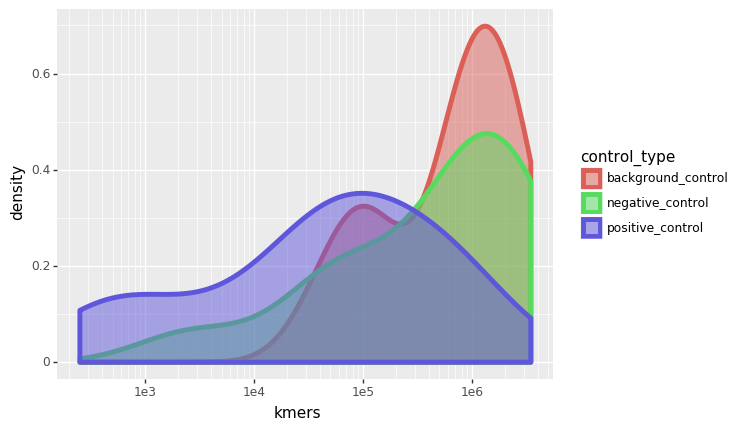

<ggplot: (-9223363296896358042)>

In [45]:
(
    ggplot(cacnes_ctrl, aes(x='kmers', color='control_type', fill='control_type')) +
        geom_density(alpha=0.5, size=2) +
        scale_x_log10()
)

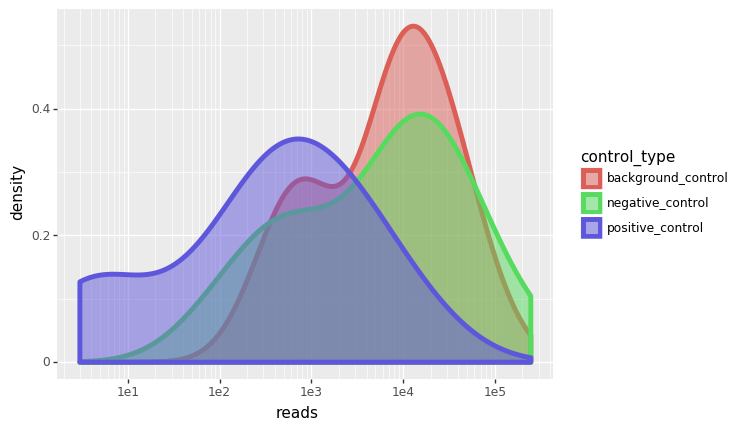

<ggplot: (-9223363296896358112)>

In [46]:
(
    ggplot(cacnes_ctrl, aes(x='reads', color='control_type', fill='control_type')) +
        geom_density(alpha=0.5, size=2) +
        scale_x_log10()
)

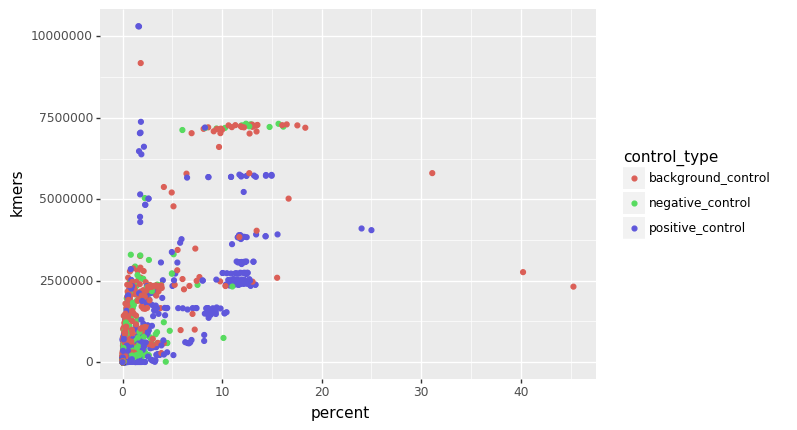

<ggplot: (8739942690873)>

In [47]:
(
    ggplot(long_ctrls, aes(x='percent', y='kmers', color='control_type', fill='control_type')) +
        geom_point()
)

In [48]:
long_ctrls

,sample,taxa_name,taxa_id,rank,mpa,reads,kmers,dup,cov,percent,tax_reads,kmer_read_ratio,control_type
284678,haib17CEM5106_HCCGHCCXY_SL270259,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,602,94038,1.25,0.022710,0.017140,581,156.209302,positive_control
284679,haib17CEM5106_HCCGHCCXY_SL270259,Cutibacterium avidum,33010,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,3,241,1.07,0.000060,0.000085,0,80.333333,positive_control
284680,haib17CEM5106_HCCGHCCXY_SL270259,Cutibacterium granulosum,33011,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,13,1055,1.21,0.000513,0.000370,0,81.153846,positive_control
284681,haib17CEM5106_HCCGHCCXY_SL270260,Cutibacterium acnes,1747,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,141,22072,1.23,0.005329,0.019000,138,156.539007,positive_control
284682,haib17CEM5106_HCCGHCCXY_SL270260,Cutibacterium granulosum,33011,species,p__Actinobacteria;c__Actinobacteria;o__Propion...,6,655,1.19,0.000319,0.000808,0,109.166667,positive_control
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37748921,haib17DB4959_H3MGVCCXY_SL259987,Enterococcus phage EF62phi,977801,species,s__Enterococcus_phage_EF62phi,138,9907,2.06,0.327400,0.006563,0,71.789855,background_control
37751004,haib17CEM5106_HCY5HCCXY_SL270998,uncultured crAssphage,1211417,species,s__uncultured_crAssphage,33,3041,1.37,0.031340,0.000714,0,92.151515,negative_control
37751070,haib17DB4959_H3MGVCCXY_SL259936,uncultured crAssphage,1211417,species,s__uncultured_crAssphage,3,252,1.87,0.002597,0.000085,0,84.000000,negative_control
37751079,haib17DB4959_H3MGVCCXY_SL259987,uncultured crAssphage,1211417,species,s__uncultured_crAssphage,13,946,1.61,0.009750,0.000618,0,72.769231,background_control


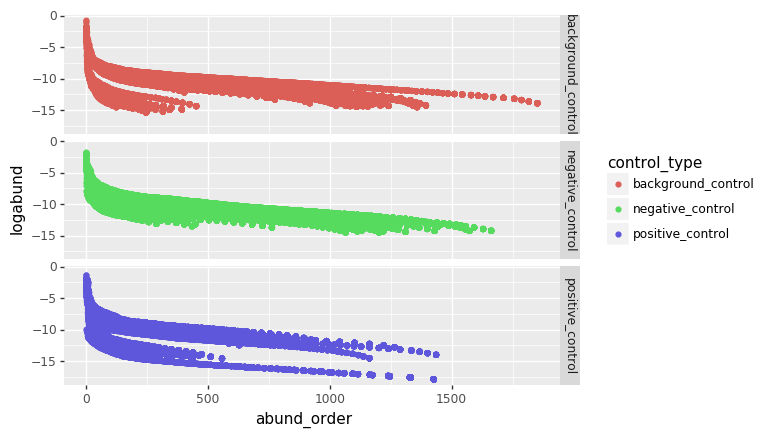

<ggplot: (-9223363296904349629)>

In [49]:

long_ctrls['logabund'] = np.log(long_ctrls['percent'] / 100)
def order_abunds(tbl):
    tbl['abund_order'] = tbl['percent'].rank(ascending=False)
    return tbl

long_ctrls = long_ctrls.groupby('sample').apply(order_abunds)

(
    ggplot(long_ctrls, aes(x='abund_order', y='logabund', color='control_type')) +
        geom_point() +
        facet_grid('control_type~.')
)



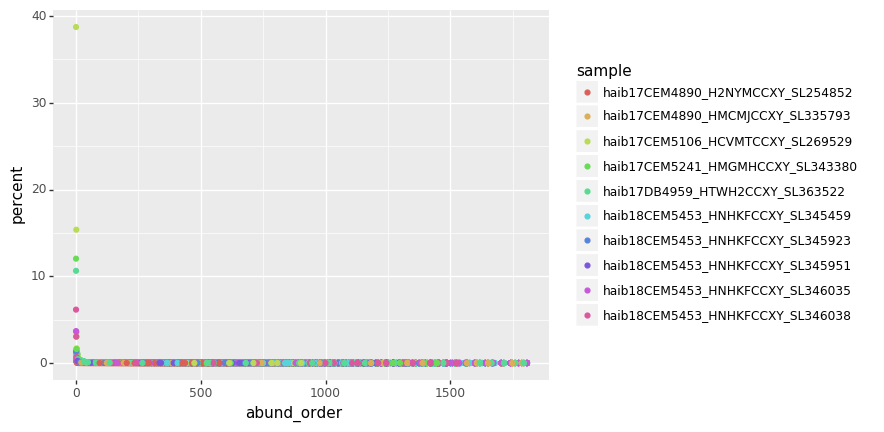

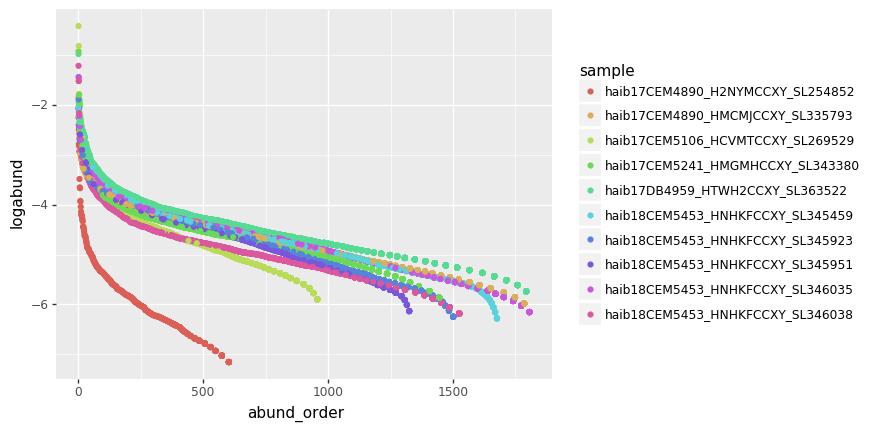

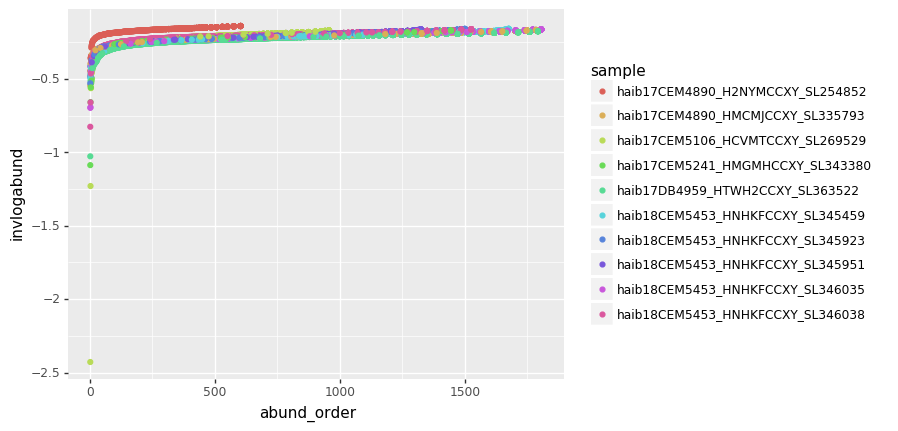

[<ggplot: (8739945029489)>,
 <ggplot: (8739945029552)>,
 <ggplot: (8739945029594)>]

In [50]:

samples = figs.meta.index.to_series().sample(10)
ltaxa = figs.long_taxa.loc[figs.long_taxa['sample'].isin(samples)]

ltaxa['logabund'] = np.log10(ltaxa['percent'] / 100)
ltaxa['invlogabund'] = 1 / np.log10(ltaxa['percent'] / 100)
def order_abunds(tbl):
    tbl['abund_order'] = tbl['percent'].rank(ascending=False)
    return tbl

ltaxa = ltaxa.groupby('sample').apply(order_abunds)

[
(
    ggplot(ltaxa, aes(x='abund_order', y='percent', color='sample')) +
        geom_point()
),
(
    ggplot(ltaxa, aes(x='abund_order', y='logabund', color='sample')) +
        geom_point()
),
(
    ggplot(ltaxa, aes(x='abund_order', y='invlogabund', color='sample')) +
        geom_point()
)
]



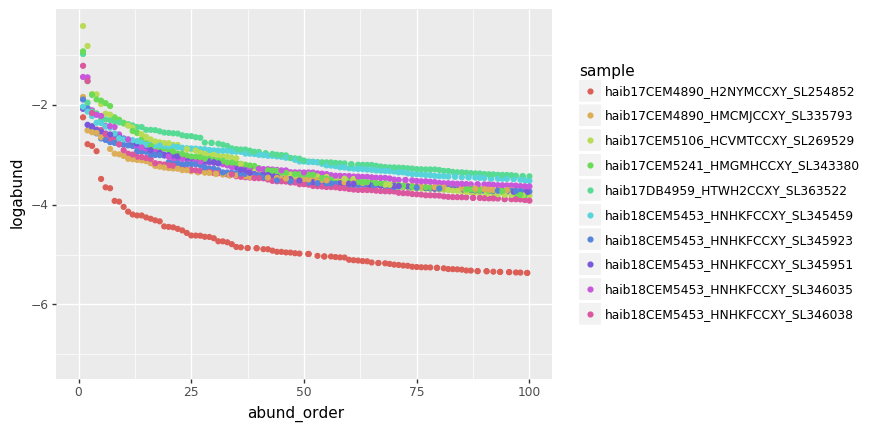

<ggplot: (8739941003191)>

In [51]:
(
    ggplot(ltaxa, aes(x='abund_order', y='logabund', color='sample')) +
        geom_point() +
        xlim(0, 100)
)

In [43]:
figs.meta.query('project == "CSD16"')

,metasub_name,core_project,project,city,city_code,latitude,longitude,surface_material,control_type,elevation,...,index_sequence,location_type,hudson_alpha_uid,other_project_uid,sample_type,sl_name,surface_ontology_fine,surface_ontology_coarse,coastal,city_elevation
uuid,,,,,,,,,,,,,,,,,,,,,
haib17KIU4866_H7HJMCCXY_SL272833,CSD16-LIS-CTRL-AIRPORT,core,CSD16,Lisbon,LIS,NaN,NaN,NaN,NaN,NaN,...,CATCCGA,NaN,haib17KIU4866_H7HJMCCXY_SL272833,NaN,NaN,SL272833,NaN,NaN,coastal,coastal
haib17KIU4866_H7HJMCCXY_SL272830,CSD16-LIS-CTRL-LINEA,core,CSD16,Lisbon,LIS,NaN,NaN,NaN,NaN,NaN,...,GTATACA,NaN,haib17KIU4866_H7HJMCCXY_SL272830,NaN,NaN,SL272830,NaN,NaN,coastal,coastal
haib17KIU4866_H7HJMCCXY_SL272831,CSD16-LIS-CTRL-LINEC,core,CSD16,Lisbon,LIS,NaN,NaN,NaN,NaN,NaN,...,AGATCCC,NaN,haib17KIU4866_H7HJMCCXY_SL272831,NaN,NaN,SL272831,NaN,NaN,coastal,coastal
haib17KIU4866_H7HJMCCXY_SL272832,CSD16-LIS-CTRL-LINED,core,CSD16,Lisbon,LIS,NaN,NaN,NaN,NaN,NaN,...,GCCGTAT,NaN,haib17KIU4866_H7HJMCCXY_SL272832,NaN,NaN,SL272832,NaN,NaN,coastal,coastal
haib17KIU4866_HTWH2CCXY_SL364012,CSD16-MRS-0047,core,CSD16,Marseille,MRS,NaN,NaN,NaN,NaN,NaN,...,AATACGAA-AGGCCTGC,NaN,haib17KIU4866_HTWH2CCXY_SL364012,NaN,NaN,SL364012,NaN,NaN,coastal,coastal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
haib17CEM4890_HKC32ALXX_SL254703,CSD16-TOK-051,not_core,CSD16,Tokyo,TOK,35.601154,139.684639,wood,NaN,NaN,...,GTGAAGC,school,haib17CEM4890_HKC32ALXX_SL254703,NaN,environmental_microbiome,SL254703,biological,permeable,coastal,coastal
haib17CEM4890_HKC32ALXX_SL254715,CSD16-TOK-052,not_core,CSD16,Tokyo,TOK,35.601154,139.684639,wood,NaN,NaN,...,GTGAGGT,school,haib17CEM4890_HKC32ALXX_SL254715,NaN,environmental_microbiome,SL254715,biological,permeable,coastal,coastal
haib17CEM4890_HKC32ALXX_SL254727,CSD16-TOK-053,not_core,CSD16,Tokyo,TOK,35.601145,139.684608,wood,NaN,NaN,...,GAGCTAG,school,haib17CEM4890_HKC32ALXX_SL254727,NaN,environmental_microbiome,SL254727,biological,permeable,coastal,coastal


In [44]:
figs.meta.query('project == "CSD17"')

,metasub_name,core_project,project,city,city_code,latitude,longitude,surface_material,control_type,elevation,...,index_sequence,location_type,hudson_alpha_uid,other_project_uid,sample_type,sl_name,surface_ontology_fine,surface_ontology_coarse,coastal,city_elevation
uuid,,,,,,,,,,,,,,,,,,,,,
haib18CEM5432_HTVVJCCXY_SL366925,232022123.0,core,CSD17,Rio De Janeiro,RIO,-22.930078,-43.183314,wood,NaN,NaN,...,CAGACACC-TCCGGTTG,park,haib18CEM5432_HTVVJCCXY_SL366925,NaN,NaN,SL366925,biological,permeable,coastal,coastal
haib18CEM5432_HTVVJCCXY_SL366920,232022136.0,core,CSD17,Rio De Janeiro,RIO,-22.984402,-43.189080,granite,NaN,NaN,...,TACTCCAG-CAATAGAG,park,haib18CEM5432_HTVVJCCXY_SL366920,NaN,NaN,SL366920,stone,impermeable,coastal,coastal
haib18CEM5432_HTVVJCCXY_SL366922,232022159.0,core,CSD17,Rio De Janeiro,RIO,-22.930413,-43.183655,wood,NaN,NaN,...,ACAGCTCC-CCAGAACC,park,haib18CEM5432_HTVVJCCXY_SL366922,NaN,NaN,SL366922,biological,permeable,coastal,coastal
haib18CEM5432_HTVVJCCXY_SL366917,232022176.0,core,CSD17,Rio De Janeiro,RIO,-22.934125,-43.180863,rubber,NaN,NaN,...,TGCCTCCT-TAGACTCT,station,haib18CEM5432_HTVVJCCXY_SL366917,NaN,NaN,SL366917,plastic,impermeable,coastal,coastal
haib18CEM5432_HTVVJCCXY_SL366930,232022178.0,core,CSD17,Rio De Janeiro,RIO,-22.896729,-43.180582,rubber,NaN,NaN,...,ATCCTCTA-CCAACCTC,station,haib18CEM5432_HTVVJCCXY_SL366930,NaN,NaN,SL366930,plastic,impermeable,coastal,coastal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
haib18CEM5432_HTWH2CCXY_SL365967,235030347.0,not_core,CSD17,Nan,NaN,NaN,NaN,NaN,NaN,NaN,...,ACAGCTCC-CCAGAACC,NaN,haib18CEM5432_HTWH2CCXY_SL365967,NaN,NaN,SL365967,NaN,NaN,low altitude,not_coastal
haib18CEM5432_HTVVJCCXY_SL366991,235030373.0,not_core,CSD17,Nan,NaN,NaN,NaN,NaN,NaN,NaN,...,CCGGCAGT-TACAGACG,NaN,haib18CEM5432_HTVVJCCXY_SL366991,NaN,NaN,SL366991,NaN,NaN,low altitude,not_coastal
haib18CEM5432_HTWH2CCXY_SL365956,235030375.0,not_core,CSD17,Nan,NaN,NaN,NaN,NaN,NaN,NaN,...,AGAGTGAA-CTTAGGCG,NaN,haib18CEM5432_HTWH2CCXY_SL365956,NaN,NaN,SL365956,NaN,NaN,low altitude,not_coastal


In [68]:
csd16 = figs.meta.query('project == "CSD16"')
csd17 = figs.meta.query('project == "CSD17"')
shared_cities = set(csd16['city']) & set(csd17['city'])
shared_cities = {
     'Bogota',
     'Denver',
     'Doha',
     'Ilorin',
     'Marseille',
     'New York City',
     'Offa',
     'Tokyo',
}

csd16_shared = csd16.query('city in @shared_cities')
csd17_shared = csd17.query('city in @shared_cities')
shared_meta = pd.concat([csd16_shared, csd17_shared])
print(shared_meta.shape)
shared_meta_samples = set(shared_meta.index) & set(figs.wide_taxa_rel.index)
shared_meta = shared_meta.loc[shared_meta_samples]
print(shared_meta.shape)

shared_cities

(1158, 42)
(1128, 42)


{'Bogota',
 'Denver',
 'Doha',
 'Ilorin',
 'Marseille',
 'New York City',
 'Offa',
 'Tokyo'}

In [74]:

from scipy.spatial.distance import cdist
from umap import UMAP

taxa = figs.wide_taxa_rel.loc[shared_meta.index]

def run_umap(mytbl, **kwargs):
    """Retrun a Pandas dataframe with UMAP, make a few basic default decisions."""
    metric = 'manhattan'
    if mytbl.shape[0] == mytbl.shape[1]:
        metric = 'precomputed'
    n_comp = kwargs.get('n_components', 2)
    umap_tbl = pd.DataFrame(UMAP(
        n_neighbors=kwargs.get('n_neighbors', min(100, int(mytbl.shape[0] / 4))),
        n_components=n_comp,
        metric=kwargs.get('metric', metric),
        random_state=kwargs.get('random_state', 42)
    ).fit_transform(mytbl))
    umap_tbl.index = mytbl.index
    umap_tbl = umap_tbl.rename(columns={i: f'UMAP-C{i}' for i in range(n_comp)})
    return umap_tbl


taxa_umap = run_umap(taxa > 0, n_neighbors=100, metric='jaccard')
taxa_umap['City'] = shared_meta['city']
taxa_umap['Project'] = shared_meta['project']
taxa_umap

,UMAP-C0,UMAP-C1,City,Project
uuid,,,,
haib17DB4959_HTWH2CCXY_SL363565,9.646516,10.463860,New York City,CSD17
haib18CEM5453_HMGW3CCXY_SL342604,5.153693,11.427436,Tokyo,CSD17
haib17KIU4866_H7HJMCCXY_SL272755,3.402081,5.645623,Ilorin,CSD16
haib17KIU4866_HTWH2CCXY_SL364018,8.225248,8.873559,Marseille,CSD16
haib18CEM5453_HMGTJCCXY_SL342597,5.219604,11.329777,Tokyo,CSD17
...,...,...,...,...
haib18CEM5453_HMGN5CCXY_SL344647,5.721196,5.984661,Offa,CSD17
haib17KIU4866_HTWH2CCXY_SL364025,9.073425,9.545753,Marseille,CSD16
haib18CEM5453_HMGN5CCXY_SL344651,6.894446,5.598839,Offa,CSD17


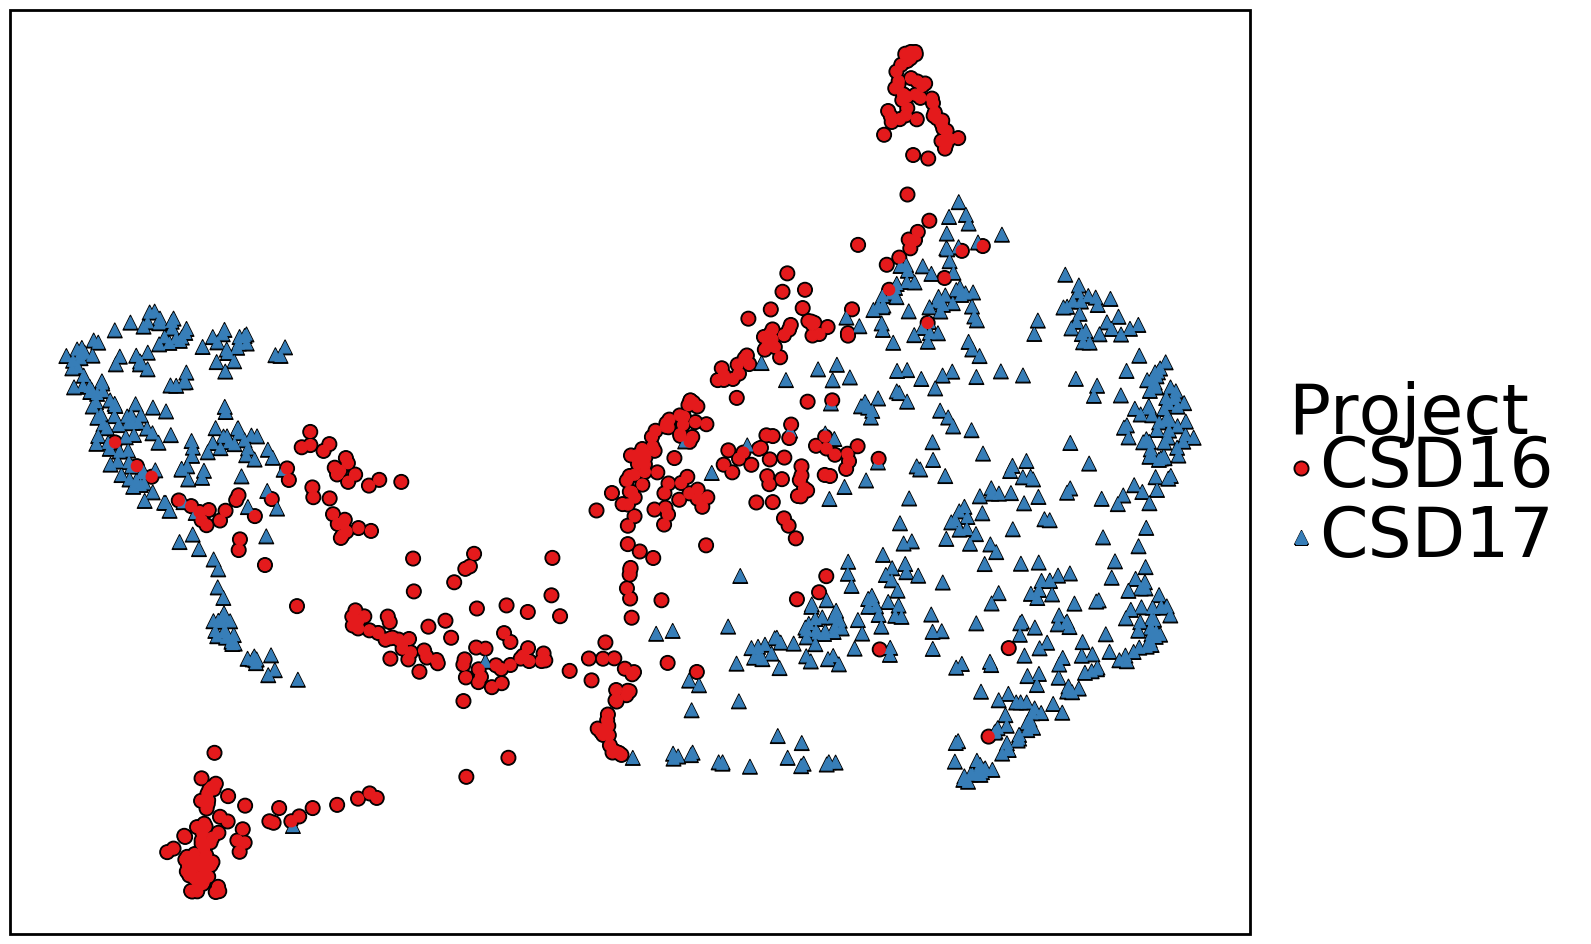

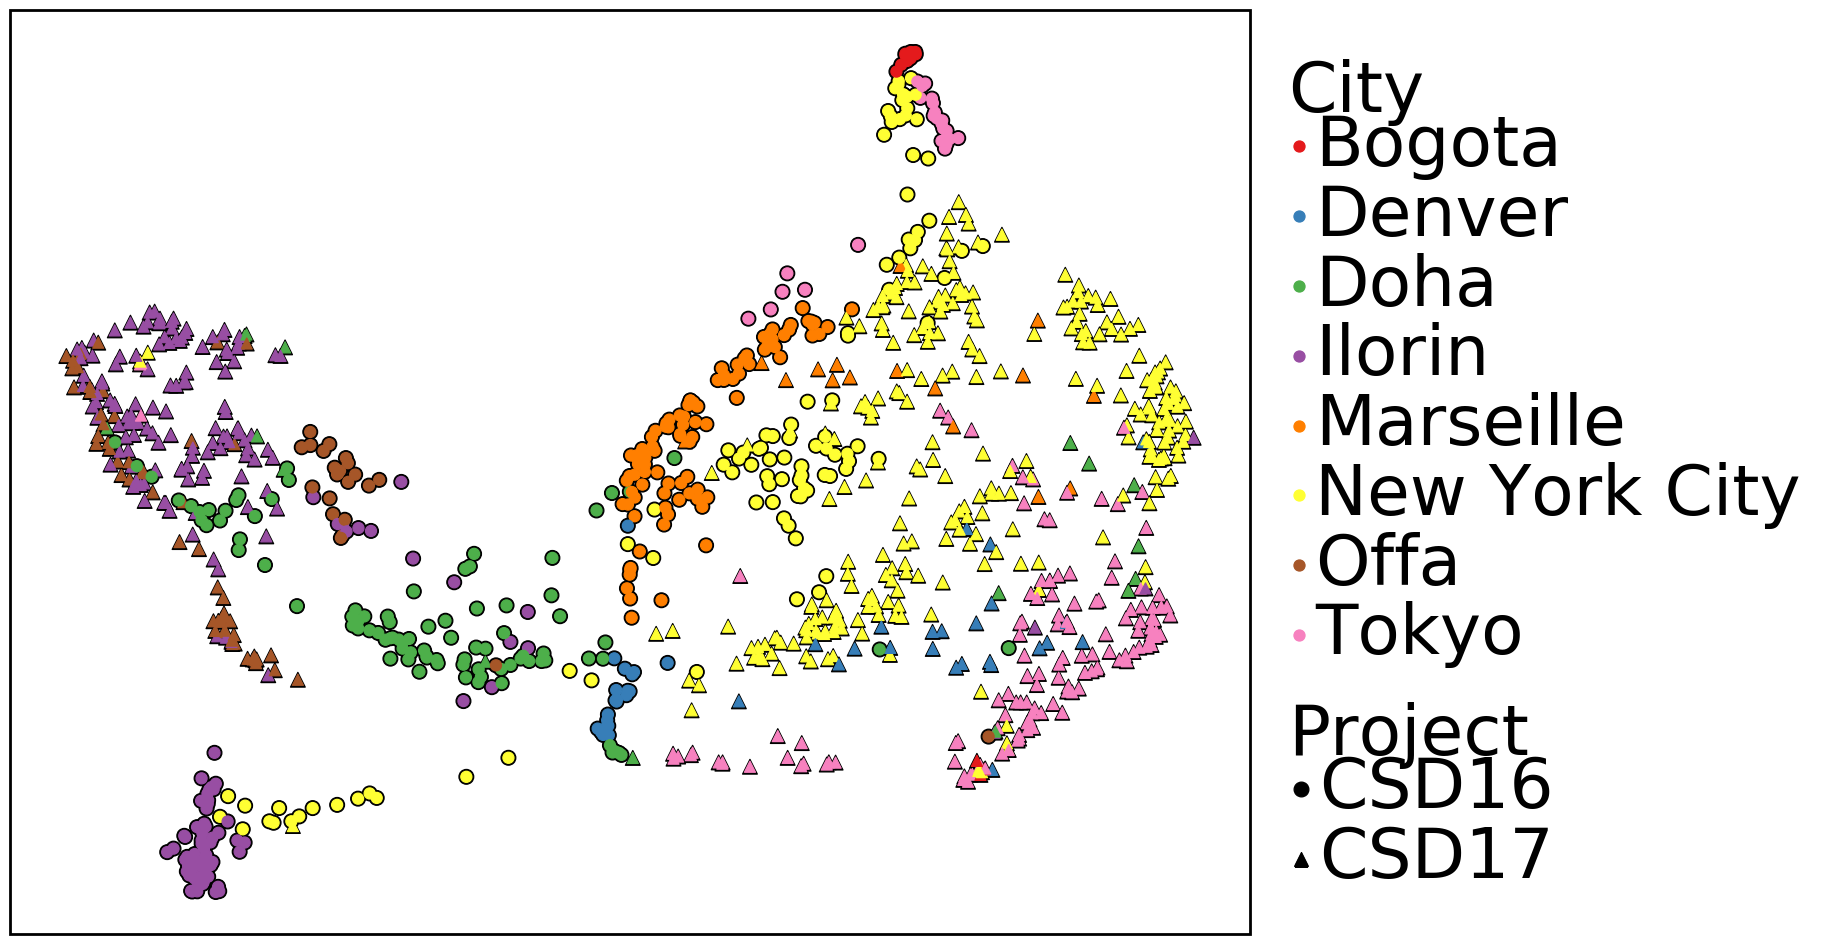

[<ggplot: (-9223363266402573589)>, <ggplot: (8770454062996)>]

In [75]:
[
    (
        ggplot(taxa_umap, aes(x='UMAP-C0', y='UMAP-C1', color='Project', shape='Project')) +
            geom_point(size=5.5, colour="black") +
            geom_point(size=4) +
            theme_minimal() +
            scale_color_brewer(type='qualitative', palette=6, direction=1) +
            theme_minimal() +
            coord_flip() +
            theme(
                text=element_text(size=50),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank(),
                legend_position='right',
                axis_text_x=element_blank(),
                axis_title_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_y=element_blank(),
                panel_border=element_rect(colour="black", fill='none', size=2),
                figure_size=(16, 12),
            )
    ),
    (
        ggplot(taxa_umap, aes(x='UMAP-C0', y='UMAP-C1', color='City', shape='Project')) +
            geom_point(size=5.5, colour="black") +
            geom_point(size=4) +
            theme_minimal() +
            scale_color_brewer(type='qualitative', palette=6, direction=1) +
            theme_minimal() +
            coord_flip() +
            theme(
                text=element_text(size=50),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank(),
                legend_position='right',
                axis_text_x=element_blank(),
                axis_title_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_y=element_blank(),
                panel_border=element_rect(colour="black", fill='none', size=2),
                figure_size=(16, 12),
            )
    ),
]

In [ ]:
(
    ggplot(taxa_umap, aes(x='UMAP-C0', y='UMAP-C1', color='City', shape='Project')) +
        geom_point(size=5.5, colour="black") +
        geom_point(size=4) +
        stat_ellipse(aes(group='City'), size=2, level=.8) +
        theme_minimal() +
        scale_color_brewer(type='qualitative', palette=6, direction=1) +
        theme_minimal() +
        coord_flip() +
        theme(
            text=element_text(size=50),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            legend_position='right',
            axis_text_x=element_blank(),
            axis_title_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_y=element_blank(),
            panel_border=element_rect(colour="black", fill='none', size=2),
            figure_size=(16, 12),
        )
)

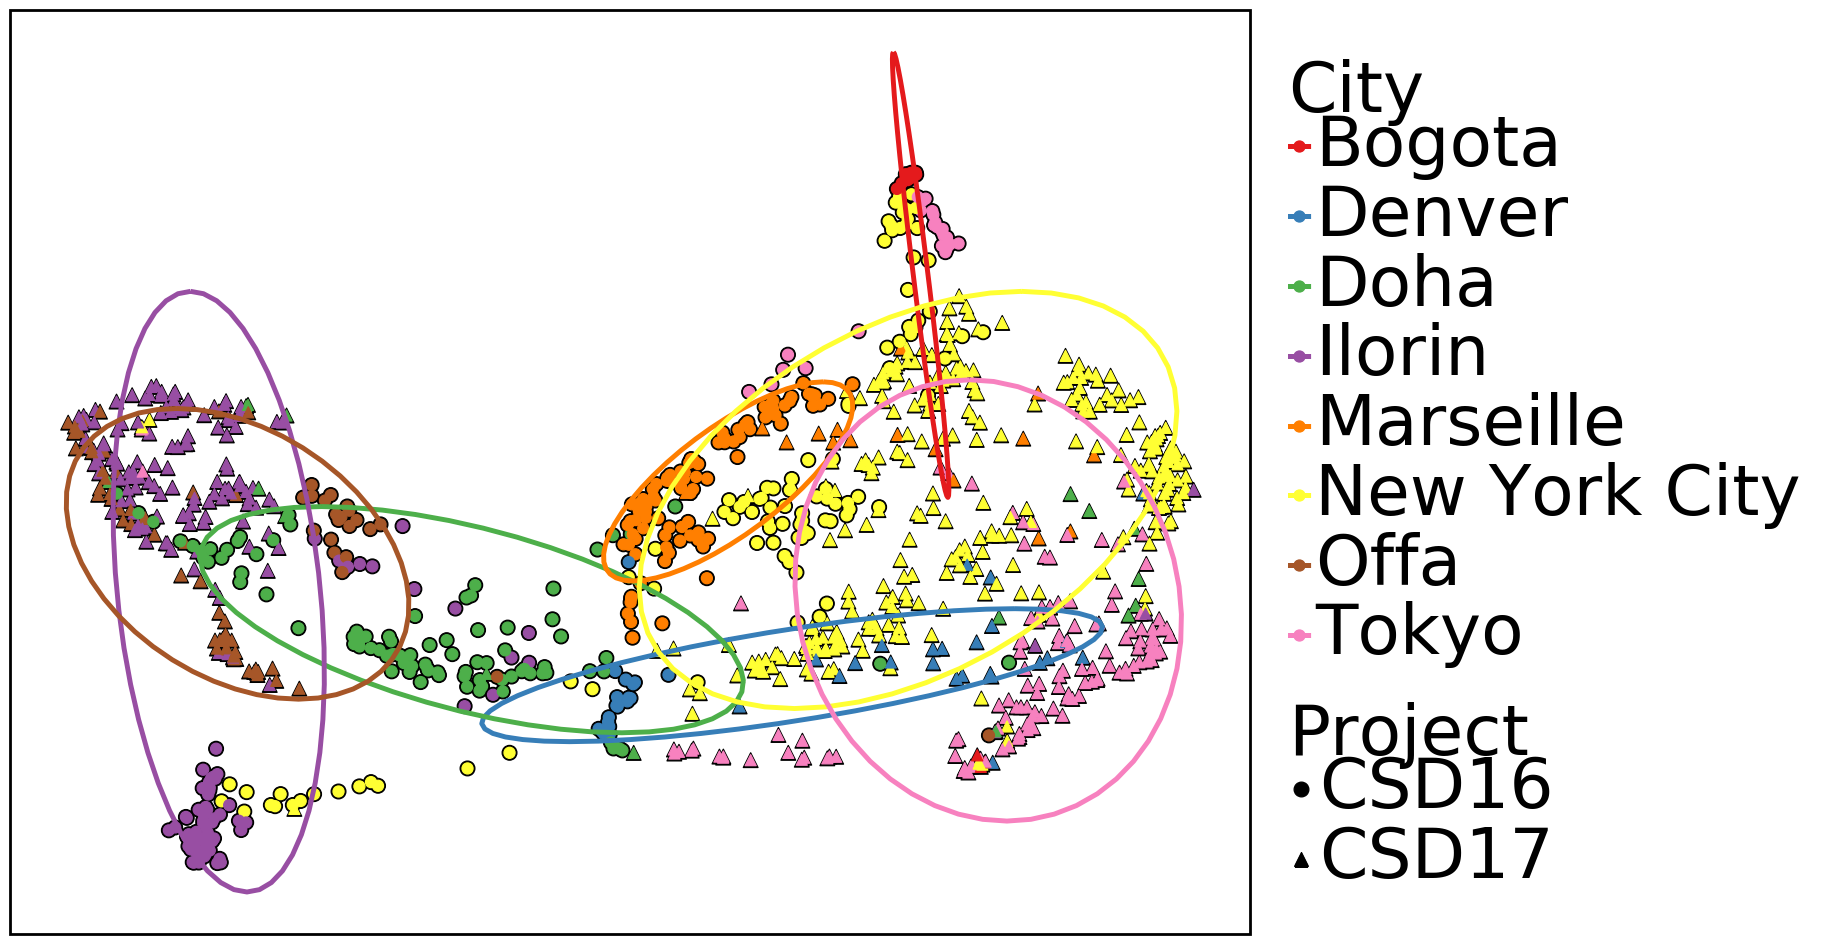

<ggplot: (-9223363266400728916)>

In [81]:
(
    ggplot(taxa_umap, aes(x='UMAP-C0', y='UMAP-C1', color='City', shape='Project')) +
        geom_point(size=5.5, colour="black") +
        geom_point(size=4) +
        stat_ellipse(aes(group='City'), size=2, level=.8) +
        theme_minimal() +
        scale_color_brewer(type='qualitative', palette=6, direction=1) +
        theme_minimal() +
        coord_flip() +
        theme(
            text=element_text(size=50),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            legend_position='right',
            axis_text_x=element_blank(),
            axis_title_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_y=element_blank(),
            panel_border=element_rect(colour="black", fill='none', size=2),
            figure_size=(16, 12),
        )
)